# Sentiment analysis of web-scraped data

### In this project, we do sentiment analysis on food review data scraped from Yelp. The project contains three main parts:

### (1) Scrape data from websites of interest

### (2) Based on scraped data, design word vectors

### (3) Use self-designed word vectors to do sentiment analysis on scraped data<br>


 Please note that we could also use pre-trained word vectors provided by Standford University to do sentiment analysis in this project. But instead, we mainly focused on training our own word vectors based on the data that we scraped because being able to understand the mathematical foundation behind designing word vectors are much more important than just using pre-trained word vectors. Once we understand it, we can design custom word vectors and apply them to anywhere we want.<br><br>
 In this project, applying pre-trained word vectors to sentiment analysis was also demonstrated. The results showed that the model using self-trained custom word vectors yielded a slightly higher accuracy than the model using pre-trained word vectors. The gist of this project is that mathematics plays an important role in the field of NLP, or in machine learning in general.

In [10]:
from selenium import webdriver
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import pairwise_distances
from sklearn.manifold import TSNE
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
import re
import os
import json
from matplotlib import pyplot as plt

## Section I: Web scraping 

### This section is about scraping food review data from Yelp.

### Food reviews were scraped from fourteen local Asian style (Chinese and Japanese) restaurants in Philadelphia, PA, United States 
### Restaurants include Han Dynasty, Dim Sum Garden, Sang Kee Noodle House, etc.
### There are totally 9909 reviews scraped. Time consumed: ~ 30 mins.

### Demos on restaurants' websites:<br><br>

### Dim Sum Garden
![Dim Sum Garden](https://i.imgur.com/usJOqO4.jpg)


### Sang Kee Noodle House
![Sang Kee Noodle House](https://i.imgur.com/IBQPgw5.jpg)

### Han Dynasty
![Han Dynasty](https://i.imgur.com/oionRn1.png)<br><br>

### For a typical Yelp review, as shown below, we would have the consumer's profile, rating, review texts, photos taken from his/her dining experience, and a section where other people could interact with this review. For our purpose of scraping, what we really care about is the rating and review text from each consumer.<br><br>

![Yelp Review Demo](https://i.imgur.com/FRYLOw6.png)

### The rating and review text squared above are what we want to scrape.
### There are some non-trivial subtleties on which we should pay careful attention while scraping. One of them is that if we look at Yelp reviews from each consumer carefully, we would find that there are some minor differences in format among different Yelp reviews. Let's look at an example.
### Below are two common Yelp reviews. One of them does not have the "check-in/photo" marker section probably because this consumer didn't do check-in on Yelp when dining and upload any photo for this review, which is very common. Consumers do not have to do check-in on Yelp to dine or do not have to upload photos when writing reviews. However, this makes a difference on HTML format. Therefore,  we need to be alert and look for the HTML pattern to make sure what we scrape is what we truly want.<br><br>

### Yelp Review 1<br>
![Yelp Review Demo](https://i.imgur.com/EziPTzn.png)
### Yelp Review 2<br>
![Yelp Review Demo](https://i.imgur.com/5q8qMvD.png)


### The ratings and review texts are stored as a tuple for each consumer.
### After scraping all the data, data pre-processing was performed.

In [2]:
class web_scraper_yelp():
    
    def __init__(self,websites,pages,question_mark):
        
        self.websites = websites
        self.pages = pages
        self.review_rating = None
        self.question_mark = question_mark
        
           
        
    def scrape(self):
        
        driver = webdriver.Chrome()
        self.review_rating = []
        
        for order, website in enumerate(self.websites):
            
            driver.get(website)
            
            current_url = driver.current_url
            
            
            pages = range(0,self.pages[order])
            
            question_mark = self.question_mark[order]
            
            for p in pages:
                
                i = 0
                flag_text = True
                print("Collecting reviews from Page %s"% str(p+1))
                if p > 0: 
                    #For yelp, normally, one page contains 20 reviews of customers
                    p = p*20
                    try:
                        if question_mark == True:
                            driver.get(current_url+"?start="+str(p))            
                        else:
                            driver.get(current_url+"&start="+str(p))

                    except:
                        
                        print('End of scraping.')

                while flag_text==True:

                    i+=1

                    most_recent_rating_xpath = '//*[@id="wrap"]/div[4]/div/div[4]/div/div/div[2]/div[1]/div[3]/section[2]/div[2]/div/ul/li['+str(i)+\
                                    ']/div/div[2]/div[1]/div/div[1]/span/div'

                    multi_reviews_path = '//*[@id="wrap"]/div[4]/div/div[4]/div/div/div[2]/div[1]/div[3]/section[2]/div[2]/div/ul/li['+\
                                str(i)+']/div/div[2]/*'

                    children_elements_lst = []

                    children_xpath = '//*[@id="wrap"]/div[4]/div/div[4]/div/div/div[2]/div[1]/div[3]/ \
                    section[2]/div[2]/div/ul/li[' + str(i) + ']/div/div[2]/div[3]//*'

                    children_elements = driver.find_elements_by_xpath(children_xpath)

                    for e in children_elements:
                        
                        children_elements_lst.append(e.tag_name)

                    if 'p' in children_elements_lst:  

                        most_recent_review_xpath = '//*[@id="wrap"]/div[4] \
                            /div/div[4]/div/div/div[2]/div[1]/div[3]/section[2]/div[2]/div/ul/li[' + str(i) + '] \
                            /div/div[2]/div[3]/p/span'

                    else:
                        most_recent_review_xpath = '//*[@id="wrap"]/div[4] \
                            /div/div[4]/div/div/div[2]/div[1]/div[3]/section[2]/div[2]/div/ul/li[' + str(i) + '] \
                            /div/div[2]/div[2]/p/span'        

                    try:
                        
                        reviews = []
                        most_rencent_review = driver.find_element_by_xpath(most_recent_review_xpath).text
                        most_recent_rating = int(driver.find_element_by_xpath(most_recent_rating_xpath).get_attribute("aria-label")[0])
                        reviews.append((most_rencent_review,most_recent_rating))
                        self.review_rating.append(reviews)
                        
                    
                    except:
                        
                        flag_text=False

            print("Total %s texts scraped so far." % len(self.review_rating))
            
            if order != len(self.websites)-1:
                
                print("Move on to the next website.")
          
        
        print("Scraping is done.")
            
    def save(self,savedir,reviews):
        
        """Save the scraped data."""
        if not os.path.exists(savedir):
            os.mkdir(savedir)

        # save the scraped data as json file
        with open('%s/yelp_reviews.json' % savedir, 'w') as f:
            json.dump(reviews,f)

    def load(self,loaddir):
        
        """Load the scraped data."""
        try:
            with open('%s/yelp_reviews.json' % loaddir) as f:
                reviews = json.load(f)

            return reviews

        except:

            print("Files are not found.")

            return None
    

In [3]:
class data_collection():
    
    def __init__(self):

        self.texts = None
        self.labels = None  
        
    def collect(self,reviews):
        
        self.texts = []
        self.labels = []
        
        for review_per_person in reviews:

            for review in review_per_person:

                text = review[0]
                rating = review[1]
                self.texts.append(text)
                self.labels.append(rating)
    

## Section II: Design word vectors

### This section is about designing our own word vectors based on scraped data from Section I.
### The algorithm for training word vectors is originated from GloVe algorithm by Standford University. One of the essential points of this algorithm is to borrow Matrix Factorization technique from the field of Recommender Systems.
### The method used for minimizing the cost function is alternating least squares (ALS).
### This section studied the GloVe algorithm from the original research paper by Standford University and transferred the algorithm into codes.
### This section is math-heavy.

In [4]:
class word_vector_preprocess():
    
    """
    This class receives web-scraped data, and does data pre-processing for creating word vectors later.
    
    """
    
    def __init__(self):
        
        self.word2indx = None
        self.indx2word = None
        self.sentences_index = None
        self.most_freq = None
             
        
    
    def preprocess(self,texts):
        
        word_freq={}
        docs = []
        regex = '[^a-z0-9]'
        for text in texts:
            text = text.lower()
            text = re.sub(regex,' ',text)
            tokens = text.split()
            docs.append(tokens)

            # Count word frequency
            for w in tokens:
                if w not in word_freq:
                    word_freq[w] = 0
                word_freq[w]+=1  
        
        return word_freq,docs
    

    def wordindx_mapping(self,texts,M):
        
        print ("data preprocessing...")
        
        word_freq, docs = self.preprocess(texts)
        
        print ("Done.")
        
        # Choose M most frequent words as V (Note: M is a hyperparameter)
        self.most_freq = sorted(word_freq.items(),key=lambda x: x[1],reverse=True)[:M]   
        self.word2indx = {w[0]:i for i,w in enumerate(self.most_freq)}
        # add a unknown key because when mapping all the sentences later by using the map, if this key does
        #not exist, the mapping will lead to error
        #Note: However, this unknown key won't actually be trained because there is a great chance that this key 
        #will become a highly (probably the most) frequent key according to its times of appearance in sentences
        #and highly frequent keys will be dropped out later.
        self.word2indx['<<UNK>>'] = M
        self.indx2word = {v:k for k,v in self.word2indx.items()}
        self.sentences_index = []
        print ("generating sentences...")
        for sent in docs:
            sent_index = []
            for w in sent:
                if w in self.word2indx:
                    sent_index.append(self.word2indx[w])
                else:
                    sent_index.append(self.word2indx['<<UNK>>'])

            self.sentences_index.append(sent_index)  
        print("Done.")

In [6]:
class word_vector_ALS():
    """
    This class is aimed to train the word vectors by ALS.
    
    """
    def __init__(self,V,context_size,D):
        
        self.context_size = context_size
        self.V = V
        self.D = D
        # create word-by-word matrix
        self.X = np.zeros((V,V))
        # Matrix Factorizaton: X = W*(U.T)
        self.W = None
        self.U = None
        # bias terms 
        self.b = None
        self.c = None
        # global mean
        self.mu = 0
          
    def dropout(self,sentences,balance_factor=0.75,threshold=1e-5,eta=1e-8):
        
        """
        Dropout on most frequent words, for example, if the probability of a word appearing in a sentence is more than
        90%, then we dropout this word.

        The aim of dropout is to improve the training. For example, word 'the' is recognized as a drop-out word. If we
        put 'the' into training dataset, no matter what role 'the' plays, either as central word or context word, 
        there will be a variety of words surrounding 'the', which means 'the' does not have a preference on its 
        relevant words. Therefore, 'the' has little contribution to the training, probably would even act as a 
        disturbation. But those drop-out words will eventually be classified together even though they don't go 
        through the training process. This is because other words all going through the training process leaves those 
        drop-out words to be classified automatically.
        
        Eta is used for smmothing because some values in the unigram will be zero which will become a hinderance when
        computing p_drop (unigram act as the denominator). Therefore, we add an eta smoothing to unigram. 
        Typical value for eta would be less than 1e-6 because we don't want to change the value of unigram too much 
        to affect the dropout.
        
        """
        
        print("generating dropout probability...")
        word_freq = np.zeros(self.V)
        total_word_count = np.sum([len(sent) for sent in sentences])
        for sent in sentences:
            for w in sent:
                word_freq[w] +=1
        
        # balance factor makes more frequent words a little bit less frequent, 
        # and less frequent words a little bit more frequent, in order to reduce the gap
        unigram = word_freq**balance_factor/np.sum(word_freq**balance_factor)
        
        # add-eta smoothing 
        unigram+=eta
        
        # threshold is a hyperparameter that decides the drop-out probability, typically around 1e-5
        # for infrequent words, p_drop will be very low, some of which will be negative
        # therefore, technically, p_drop is not a probability, but act the same as a probability.
        p_drop = 1-np.sqrt(threshold/unigram) 
        
        print("Done.")
        
        return p_drop
        
    def update_matrix(self,pos,sent):
        
        """
        Update V*V word-by-word matrix as true label for training purposes.
        """  
        start_index = max(0,pos-self.context_size)
        end_index = min(len(sent)-1,pos+self.context_size)
        context_words = []
        central_word = sent[pos]
        for i in range(start_index,end_index+1):
            # find the context words
            context_w = sent[i]
            if i<pos:
                context_words.append(context_w)
                self.X[central_word,context_w]+= (1/(pos-i))
                self.X[context_w,central_word]+= (1/(pos-i))
            elif i>pos:
                context_words.append(context_w)
                self.X[central_word,context_w]+= (1/(i-pos))
                self.X[context_w,central_word]+= (1/(i-pos))        

        
    def true_word_matrix(self,sentences,drop_out=0.90):
        """
        Create V*V word-by-word matrix as true label for training purposes.
        """
        p_drop = self.dropout(sentences)
        print("generating true word matrix...")
        for sent in sentences:
            #drop the word when p_drop is bigger than drop-out probability
            sent = [w for w in sent if p_drop[w]<drop_out]
            #check after drop-out, if it is still qualified as a sentence (abandon if less than two words)
            if len(sent) < 2:
                continue
            random_pos = np.random.choice(len(sent),size=len(sent),replace=False)

            for pos in random_pos:
                #the middle word
                word = sent[pos]
                self.update_matrix(pos,sent) 
        
        print("Done.")

    def train(self,epochs,score,lr=1e-4,lamda=0.1):
        
        """
        This is the Alternating Least Square (ALS) train method. The mathematics behind this algorithm is highly
        relevant to Matrix Factorization technique applied within the field of Recommender Systems.
        
        For an elaborate explanation on mathematics behind this algorithm, please refer to "Matrix Factorization
        on word vectors in NLP.pdf"
        
        The regularization term lamda is typically set to 0.1.
        
        The model's learning rate should be experimented for multiple times, 1e-4 is a good value to start with.
        
        """

        print("training...")
        # add-1 smoothing
        logX = np.log(self.X+1)
        V = self.V
        D = self.D
        W = np.random.randn(V,D) 
        U = np.random.randn(V,D) 
        b = np.zeros((V,1))
        c = np.zeros((V,1))
        mu = logX.mean()
        self.costs=[]
        fX = self.weight_factor(score,alpha=0.75)
        
        for e in tqdm(range(epochs)):
            
            # Compute the costs
            
            element = np.dot(W,U.T)+b+c.T+mu - logX
            cost = (fX*(element*element)).sum()
            self.costs.append(cost)

            #update W matrix 
            for i in range(V):

                matrix = (fX[i,:]*U.T).dot(U) + lamda*np.eye(D)
                vec = (fX[i,:]*(logX[i,:]-b[i]-c.reshape(-1)-mu)).dot(U)
                W[i] = np.linalg.solve(matrix,vec)
            
            #update U matrix 
            for j in range(V):

                matrix = (fX[:,j]*W.T).dot(W) + lamda*np.eye(D)
                vec = (fX[:,j]*(logX[:,j] - b.reshape(-1) - c[j] - mu)).dot(W)
                U[j] =  np.linalg.solve(matrix,vec)

            #update b vector
            for i in range(V):
                b[i] = (1/(fX[i,:].sum()+lamda))*(fX[i,:].dot(logX[i,:]-W[i,:].dot(U.T)-c.reshape(-1)-mu))

            #update c vector
            for j in range(V):
                c[j] = (1/(fX[:,j].sum()+lamda))*(fX[:,j].dot(logX[:,j] - W.dot(U[j,:]) - b.reshape(-1) - mu))

    
        self.W = W
        self.U = U
        self.b = b
        self.c = c
        self.mu = mu
    
    def weight_factor(self,score,alpha):
        
        """
        If an entry of the word-by-word matrix is less than the value of score, then add a weight factor 
        to the entry. In addition, the entry is also balanced by the alpha because we want the entry with
        much lower values to increase in a more significant way that the entry with much higher value after
        being applied by alpha. In this way, we can reduce the gap created by weight factor between entry 
        with lower value and entry with higher value. According to the research articles, adding a weight factor fX
        as well as a balanced factor alpha could generally improve the performance of the training process.
        
        score is a hyperparameter that acts as a threshold. If the entry in word-by-word matrix is higher than
        the score, then this entry would accordingly be assigned to a weight factor 1; whereas if the entry is
        lower than the score, then this entry would accordingly be assigned to a weight factor(<1) which is the 
        proportion of the entry value to the score.
        
        """
        V = self.V
        fX = np.zeros((V,V)) 
        fX[self.X<score] = (self.X[self.X<score]/float(score))**alpha
        fX[self.X>=score] = 1.0
        
        return fX 
    
    def save(self,savedir,word2indx,word_vec_options):
        
        """Save the trained variables."""
        if not os.path.exists(savedir):
            os.mkdir(savedir)

        # save the word2indx dictionary as json file
        with open('%s/word2indx_yelp_review.json' % savedir, 'w') as f:
            json.dump(word2indx,f)
        # save the trained word vectors to local PC
        np.savez('%s/W_ALS.npz' % savedir,word_vec_options[0],word_vec_options[1],word_vec_options[2])

    def load(self,loaddir):
        
        """Load the trained variables."""
        try:
            with open('%s/word2indx_ALS.json' % loaddir) as f:
                word2indx = json.load(f)
            npz = np.load('%s/W_ALS.npz' % loaddir)
            W = npz['arr_0']
            W_avg = npz['arr_1']
            W_concat = npz['arr_2']

            return (word2indx,[W, W_avg, W_concat])

        except:

            print("Files are not found.")

            return None

## Section III: Sentiment analysis with self-designed word vectors

### For sentiment analysis, Pytorch module was used to establish a training neural network.
### After some experiments, we found that deep neural networks are overwhelming to this task. Instead, we chose to use logistic regression.
### We could also build logistic regression model without using Pytorch, but in this section we would like to use Pytorch merely for the purpose of appreciating the beauty of Pytorch.
### In addition, the custom estimators were built in order to do grid-search for tuning the hyperparameters of the model.

In [7]:
class Sentiment_Analysis(nn.Module):
    
    def __init__(self,input_size,output_size):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.fc1 = nn.Linear(self.input_size,self.output_size)
        self.batch_loss = None


   
              
    def preprocess_data(self,texts,labels,word2vec,word2indx):       
        docs = []
        regex = '[^a-z0-9]'
        for text in texts:
            text = text.lower()
            text = re.sub(regex,' ',text)
            tokens = text.split()
            docs.append(tokens) 
        
        D = word2vec.shape[1]
        X = np.zeros((len(docs),D))
        Y = np.zeros(len(docs))
        
        #empty_docs_indx is used to check if there is a sentence in which every word is not in the word2vec. 
        #If there is, abandon the corresponding rows in the X and Y matrices.
        empty_docs_indx = []
        print("preprocessing...")
        for i,doc in enumerate(docs):  
                vec_lst = []
                for w in doc:
                    if w in word2indx:
                        vec = word2vec[word2indx[w],:]
                        vec_lst.append(vec)
                
                if len(vec_lst) > 0:
                        vecs = np.array(vec_lst)
                        X[i,:]=vecs.mean(axis=0)
                        Y[i] = 1 if labels[i]>3 else 0 
                else:
                    empty_docs_indx.append(i)
                    
        # Abandon the corresponding rows in the X and Y matrices where no single word appears in the word2vec. 
        X = np.delete(X,empty_docs_indx,axis=0)
        Y = np.delete(Y,empty_docs_indx,axis=0)
        print("Done.")
        
        return X,Y

    
    def generate_data(self,texts,labels,word2vec,word2indx,train_test_split):
        
        X, Y = self.preprocess_data(texts,labels,word2vec,word2indx)
        data = [(x,y) for x,y in zip(X,Y)]
        np.random.shuffle(data)
        data_pos = [tup for tup in data if tup[1]==1]
        data_neg = [tup for tup in data if tup[1]==0]
        rand_indx_pos = np.random.choice(len(data_pos),len(data_neg),replace=False)
        data = [data_pos[i] for i in rand_indx_pos]
        data.extend(data_neg)
        np.random.shuffle(data)
        training = data[:int(len(data)*train_test_split)]
        testing = data[int(len(data)*train_test_split):]
        X_train = np.array([x[0] for x in training])
        Y_train = np.array([x[1] for x in training])
        X_test = np.array([x[0] for x in testing])
        Y_test = np.array([x[1] for x in testing])
        
        return X_train,Y_train,X_test,Y_test
    
    
    
        
    def forward(self,X,CrossEntropy):
        output = self.fc1(X)
        output = torch.sigmoid(output)
        if CrossEntropy == False:
            output = F.softmax(output,dim=1)         
        return output 
    
    
    def train(self,epochs,batch_size,lr,CrossEntropy,X_train,Y_train):
        
        optimizer = optim.Adam(self.parameters(),lr=lr)
        loss_function = nn.CrossEntropyLoss()
        self.batch_loss=[]
        batches = int(X_train.shape[0]/batch_size) + 1
        
        print("training...")

        for epoch in tqdm(range(epochs)):
            
            for _ in range(batches):
                
                indx = np.random.choice(X_train.shape[0],batch_size,replace=False)
                x = torch.from_numpy(X_train[indx,:]).type(torch.FloatTensor)
                y = torch.from_numpy(Y_train[indx]).type(torch.LongTensor)
                self.zero_grad()
                output = self.forward(x,CrossEntropy)
                losses = loss_function(output,y)
                losses.backward()
                optimizer.step()
            self.batch_loss.append(losses)
        
        print("Done.")

    def test(self,x,y,CrossEntropy):
        
        case = 0
        correct = 0
        
        for i in range(x.shape[0]):
            
            case+=1
            tensor_x = torch.from_numpy(x[i].reshape(1,-1)).type(torch.FloatTensor)
            out = self.forward(tensor_x,CrossEntropy) 
            if out.argmax() == y[i]:
                correct+=1   
        
        acc = correct/case
        
        return acc


In [154]:
class Sentiment_Estimator(BaseEstimator,nn.Module):
    


    def __init__(self,epochs=0,batch_size=0,lr=0,CrossEntropy=True):
        super().__init__()
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.CrossEntropy = CrossEntropy
        self.fc1 = nn.Linear(150,2)
        self.batch_loss = None

    def get_params(self, deep=False):
        return {'epochs': self.epochs, 'batch_size': self.batch_size,'lr':self.lr,'CrossEntropy':self.CrossEntropy}
    
    def set_params(self, **parameters):
        self.epochs = parameters['epochs']
        self.batch_size = parameters['batch_size']
        self.lr = parameters['lr']
        self.CrossEntropy = parameters['CrossEntropy']
        return self
    
    def forward(self,X):
        output = self.fc1(X)
        output = torch.sigmoid(output)
        if self.CrossEntropy == False:
            output = F.softmax(output,dim=1)         
        return output 

    def fit(self, X_train, Y_train):
        
        optimizer = optim.Adam(self.parameters(),lr=self.lr)
        loss_function = nn.CrossEntropyLoss()
        self.batch_loss=[]
        batches = int(X_train.shape[0]/self.batch_size) + 1
        
        print("training...")

        for epoch in tqdm(range(self.epochs)):
            
            for _ in range(batches):
                
                indx = np.random.choice(X_train.shape[0],self.batch_size,replace=False)
                x = torch.from_numpy(X_train[indx,:]).type(torch.FloatTensor)
                y = torch.from_numpy(Y_train[indx]).type(torch.LongTensor)
                self.zero_grad()
                output = self.forward(x)
                losses = loss_function(output,y)
                losses.backward()
                optimizer.step()
            self.batch_loss.append(losses)
        
        print("Done.")
        
        return self


    def predict(self,X_test,Y_test):
        
        case = 0
        correct = 0
        
        for i in range(X_test.shape[0]):
            
            case+=1
            tensor_x = torch.from_numpy(X_test[i].reshape(1,-1)).type(torch.FloatTensor)
            out = self.forward(tensor_x) 
            if out.argmax() == Y_test[i]:
                correct+=1   
        
        acc = correct/case
        
        return acc
    
    def score(self,X_test,Y_test):
        
        return self.predict(X_test,Y_test)




## Main function and results

### I. Data Scraping

In [9]:
websites = ["https://www.yelp.com/biz/sampan-philadelphia-3",
            "https://www.yelp.com/biz/dim-sum-garden-philadelphia?osq=Restaurants",
            "https://www.yelp.com/biz/toms-dim-sum-philadelphia",
            "https://www.yelp.com/biz/aki-nom-nom-sushi-and-ramen-philadelphia-3",
            "https://www.yelp.com/biz/han-dynasty-philadelphia",
            "https://www.yelp.com/biz/mandarin-palace-philadelphia",
            "https://www.yelp.com/biz/square-on-square-philadelphia-3",
            "https://www.yelp.com/biz/golden-chopstick-chinese-restaurant-philadelphia",
            "https://www.yelp.com/biz/south-garden-philadelphia",
            "https://www.yelp.com/biz/golden-empress-garden-philadelphia",
            "https://www.yelp.com/biz/sang-kee-noodle-house-philadelphia?osq=Sang%20Kee%20Noodle%20House",
            "https://www.yelp.com/biz/spring-chinese-restaurant-philadelphia",
            "https://www.yelp.com/biz/dan-dan-philadelphia-6",
            "https://www.yelp.com/biz/win-wah-conshohocken"]

pages = [90,120,27,26,72,9,12,7,4,9,20,3,38,5]
question_mark = [True,False,True,True,True,True,True,True,True,True,False,True,True,True]
scraper = web_scraper_yelp(websites=websites,pages=pages,question_mark=question_mark)
scraper.scrape()

Total 1779 texts scraped so far.
Move on to the next website.
Total 4179 texts scraped so far.
Move on to the next website.
Total 4711 texts scraped so far.
Move on to the next website.
Total 5229 texts scraped so far.
Move on to the next website.
Total 6668 texts scraped so far.
Move on to the next website.
Total 6841 texts scraped so far.
Move on to the next website.
Total 7079 texts scraped so far.
Move on to the next website.
Total 7201 texts scraped so far.
Move on to the next website.
Total 7271 texts scraped so far.
Move on to the next website.
Total 7445 texts scraped so far.
Move on to the next website.
Total 7841 texts scraped so far.
Move on to the next website.
Total 7895 texts scraped so far.
Move on to the next website.
Total 8638 texts scraped so far.
Move on to the next website.
Total 8721 texts scraped so far.
Scraping is done.


### II. Word Vectors

#### Save the ratings and reviews 

Save the ratings and reviews to our local files so that we could directly load and reuse them later.

In [144]:
review_rating = scraper.review_rating
scraper.save("./",review_rating)

#### Pre-process review data for desigining word vectors

In [ ]:
collection = data_collection()
collection.collect(review_rating)
texts = collection.texts
labels = collection.labels
preprocess = word_vector_preprocess()
preprocess.wordindx_mapping(texts,M=6000)
word2indx = preprocess.word2indx
sentences = preprocess.sentences_index

#### Train word vectors  

In [12]:
model_word_vec = word_vector_ALS(V=len(word2indx),context_size=10,D=150)
model_word_vec.true_word_matrix(sentences=sentences,drop_out=0.90)
model_word_vec.train(epochs=30,score=100)
W = model_word_vec.W
U = model_word_vec.U
W_avg = (W+U)/2
W_concat = np.concatenate((W,U),axis=1)
word_vec_options = [W,W_avg,W_concat]

data preprocessing...
Done.
generating sentences...
Done.
generating dropout probability...
Done.
generating true word matrix...
Done.
training...



100%|██████████| 30/30 [44:22<00:00, 86.96s/it]

#### Plot the cost values for each epoch during the training process of word vectors

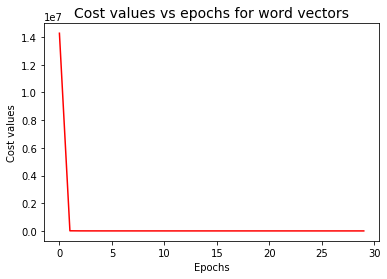

In [13]:
plt.plot(model_word_vec.costs,'r')
plt.title("Cost values vs epochs for word vectors",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.show()

#### Save the word vectors

Save the word vectors to our local files so that we could directly load and reuse them later.

In [145]:
model_word_vec.save("./",word2indx,word_vec_options)

### III. Sentiment Analysis

#### Pre-process data for sentiment analysis

Note: the data we pre-processed here is the same as what we pre-processed when training the word vectors. The reason why we want to pre-process again is because we need to pre-process the data in a different way in order to do sentiment analysis.

In [133]:
word2vec_W = word_vec_options[0]
N,D = word2vec_W.shape
model_analysis = Sentiment_Analysis(D,2)
X_train,Y_train,X_test,Y_test =model_analysis.generate_data(texts=texts,labels=labels,word2vec=word2vec_W,word2indx=word2indx,train_test_split=0.85)

preprocessing...
Done.


#### Train the model

According to Yelp reviews, people tend to consider the overall dining experience positive if 4 or 5 stars are given. On the contrary, if 3 stars are given, then generally there is at least one or two minor parts which consumers are not satisfied about. If 1 or 2 stars are given, then generally consumers are sure being negative about the overall dining experience. Therefore, a reasonable assumption was made that ratings above 3 are deemed as positive reviews, whereas ratings below 3 (inclusive) are deemed as negative reviews. 

In [134]:
model_analysis.train(epochs=2000,batch_size=256,lr=0.01,CrossEntropy=True,X_train=X_train,Y_train=Y_train)




  0%|          | 0/2000 [00:00<?, ?it/s]


  0%|          | 5/2000 [00:00<00:40, 49.44it/s]

training...





  1%|          | 12/2000 [00:00<00:37, 52.99it/s]


  1%|          | 19/2000 [00:00<00:34, 56.62it/s]


  1%|▏         | 26/2000 [00:00<00:33, 59.07it/s]


  2%|▏         | 34/2000 [00:00<00:31, 62.75it/s]


  2%|▏         | 40/2000 [00:00<00:33, 59.07it/s]


  2%|▏         | 46/2000 [00:00<00:33, 58.20it/s]


  3%|▎         | 53/2000 [00:00<00:32, 59.33it/s]


  3%|▎         | 59/2000 [00:00<00:32, 59.48it/s]


  3%|▎         | 66/2000 [00:01<00:31, 60.57it/s]


  4%|▎         | 72/2000 [00:01<00:32, 59.39it/s]


  4%|▍         | 78/2000 [00:01<00:32, 59.07it/s]


  4%|▍         | 86/2000 [00:01<00:30, 62.94it/s]


  5%|▍         | 93/2000 [00:01<00:29, 64.56it/s]


  5%|▌         | 101/2000 [00:01<00:28, 67.77it/s]


  5%|▌         | 109/2000 [00:01<00:26, 70.34it/s]


  6%|▌         | 117/2000 [00:01<00:26, 70.57it/s]


  6%|▋         | 125/2000 [00:01<00:27, 68.77it/s]


  7%|▋         | 132/2000 [00:02<00:28, 66.22it/s]


  7%|▋         | 139/2000 [00:02<00:27, 66.48it/s]


  7

Done.


#### Plot the cost values for each epoch during the sentiment analysis

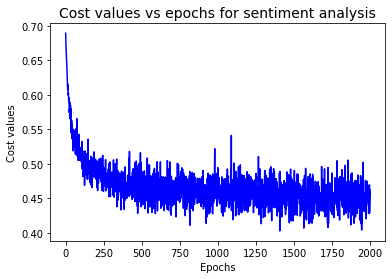

In [135]:
plt.plot(model_analysis.batch_loss,'b')
plt.title("Cost values vs epochs for sentiment analysis",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.show()

#### Test accuracy of the model

In [136]:
accuracy = model_analysis.test(X_test,Y_test,CrossEntropy=True)
accuracy 

0.8412903225806452

#### Compare the performance of different sorts of word vector matrices

In addition to W matrix, we have two other sorts of word vector matrices, average matrix and concatenated matrix.<br>
Let's have a look at the performances of the models when the other two word vector matrices are used.

#### I. average word vector matrix 

In [137]:
word2vec_avg = word_vec_options[1]
N,D = word2vec_avg.shape
model_analysis_2 = Sentiment_Analysis(D,2)
X_train_2,Y_train_2,X_test_2,Y_test_2 = model_analysis_2.generate_data(texts=texts,labels=labels,word2vec=word2vec_avg,word2indx=word2indx,train_test_split=0.85)
model_analysis_2.train(epochs=2000,batch_size=256,lr=0.01,CrossEntropy=True,X_train=X_train_2,Y_train=Y_train_2)

preprocessing...





  0%|          | 0/2000 [00:00<?, ?it/s]


  0%|          | 5/2000 [00:00<00:40, 49.62it/s]

Done.
training...





  1%|          | 11/2000 [00:00<00:38, 51.94it/s]


  1%|          | 17/2000 [00:00<00:36, 53.65it/s]


  1%|          | 24/2000 [00:00<00:35, 56.07it/s]


  2%|▏         | 31/2000 [00:00<00:33, 58.81it/s]


  2%|▏         | 39/2000 [00:00<00:31, 62.84it/s]


  2%|▏         | 47/2000 [00:00<00:29, 66.21it/s]


  3%|▎         | 55/2000 [00:00<00:27, 69.76it/s]


  3%|▎         | 63/2000 [00:00<00:27, 71.45it/s]


  4%|▎         | 71/2000 [00:01<00:26, 72.41it/s]


  4%|▍         | 79/2000 [00:01<00:26, 71.99it/s]


  4%|▍         | 87/2000 [00:01<00:26, 72.61it/s]


  5%|▍         | 95/2000 [00:01<00:25, 74.52it/s]


  5%|▌         | 103/2000 [00:01<00:25, 74.07it/s]


  6%|▌         | 111/2000 [00:01<00:28, 66.56it/s]


  6%|▌         | 118/2000 [00:01<00:29, 63.77it/s]


  6%|▋         | 125/2000 [00:01<00:30, 61.03it/s]


  7%|▋         | 132/2000 [00:01<00:30, 61.44it/s]


  7%|▋         | 139/2000 [00:02<00:31, 58.32it/s]


  7%|▋         | 147/2000 [00:02<00:29, 62.00it/s]


  

Done.


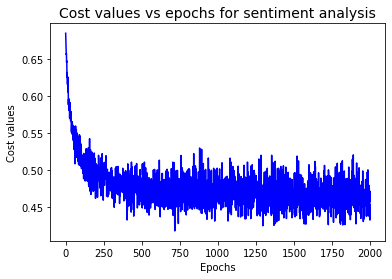

In [138]:
plt.plot(model_analysis_2.batch_loss,'b')
plt.title("Cost values vs epochs for sentiment analysis",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.show()

In [139]:
accuracy = model_analysis_2.test(X_test_2,Y_test_2,CrossEntropy=True)
accuracy 

0.8258064516129032

#### II. concatenated word vector matrix 

In [140]:
word2vec_concat = word_vec_options[2]
N,D = word2vec_concat.shape
model_analysis_3 = Sentiment_Analysis(D,2)
X_train_3,Y_train_3,X_test_3,Y_test_3 = model_analysis_3.generate_data(texts=texts,labels=labels,word2vec=word2vec_concat,word2indx=word2indx,train_test_split=0.85)
model_analysis_3.train(epochs=2000,batch_size=256,lr=0.01,CrossEntropy=True,X_train=X_train_3,Y_train=Y_train_3)

preprocessing...





  0%|          | 0/2000 [00:00<?, ?it/s]


  0%|          | 6/2000 [00:00<00:37, 53.31it/s]

Done.
training...





  1%|          | 11/2000 [00:00<00:38, 51.98it/s]


  1%|          | 16/2000 [00:00<00:40, 48.96it/s]


  1%|          | 21/2000 [00:00<00:40, 49.24it/s]


  1%|▏         | 26/2000 [00:00<00:39, 49.44it/s]


  2%|▏         | 33/2000 [00:00<00:37, 52.72it/s]


  2%|▏         | 40/2000 [00:00<00:35, 55.91it/s]


  2%|▏         | 46/2000 [00:00<00:35, 55.61it/s]


  3%|▎         | 52/2000 [00:00<00:34, 56.06it/s]


  3%|▎         | 59/2000 [00:01<00:33, 58.41it/s]


  3%|▎         | 66/2000 [00:01<00:32, 60.25it/s]


  4%|▎         | 73/2000 [00:01<00:30, 62.18it/s]


  4%|▍         | 80/2000 [00:01<00:31, 61.85it/s]


  4%|▍         | 87/2000 [00:01<00:30, 62.91it/s]


  5%|▍         | 94/2000 [00:01<00:30, 61.67it/s]


  5%|▌         | 101/2000 [00:01<00:30, 61.90it/s]


  5%|▌         | 108/2000 [00:01<00:30, 62.02it/s]


  6%|▌         | 115/2000 [00:01<00:30, 62.61it/s]


  6%|▌         | 122/2000 [00:02<00:29, 63.11it/s]


  6%|▋         | 129/2000 [00:02<00:29, 64.04it/s]


  7%

Done.


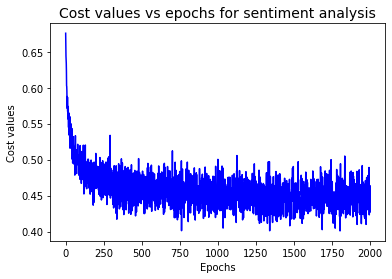

In [141]:
plt.plot(model_analysis_3.batch_loss,'b')
plt.title("Cost values vs epochs for sentiment analysis",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.show()

In [142]:
accuracy = model_analysis_3.test(X_test_3,Y_test_3,CrossEntropy=True)
accuracy 

0.807741935483871

 *As we can see from the accuracy results, three sorts of word vector matrices perform similarly on sentiment analysis.*<br><br>


#### Grid-Search on custom estimators
Build custom estimators and use scikit-learn GridSearchCV model to do grid-search on different models by tuning hyperparameters in order to find the best model.<br><br>
Since three sorts of word vectors perform similarly, we choose W word vector matrix, which performed slighly better than the others, to do grid-search.<br><br>
The hyperparameters to be tuned are epochs, batch size, and learning rate.

In [156]:
estimator = Sentiment_Estimator()
params = {'epochs':[1200,1500,2000], 'batch_size':[128,256,350],
              'lr':[0.008,1e-2,0.03],'CrossEntropy':[True]}
gridSearch = GridSearchCV(estimator, param_grid=params, n_jobs=1,
                            cv=3, verbose=1)
gridSearch.fit(X_train, Y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.




  0%|          | 0/1200 [00:00<?, ?it/s]



  0%|          | 5/1200 [00:00<00:24, 48.03it/s]

Fitting 3 folds for each of 27 candidates, totalling 81 fits
training...






  1%|          | 10/1200 [00:00<00:24, 48.21it/s]



  1%|▏         | 17/1200 [00:00<00:22, 51.68it/s]



  2%|▏         | 23/1200 [00:00<00:22, 53.09it/s]



  2%|▎         | 30/1200 [00:00<00:20, 56.51it/s]



  3%|▎         | 37/1200 [00:00<00:19, 59.74it/s]



  4%|▍         | 45/1200 [00:00<00:18, 63.08it/s]



  4%|▍         | 52/1200 [00:00<00:17, 64.53it/s]



  5%|▍         | 59/1200 [00:00<00:17, 65.02it/s]



  6%|▌         | 66/1200 [00:01<00:17, 64.78it/s]



  6%|▌         | 73/1200 [00:01<00:17, 65.87it/s]



  7%|▋         | 80/1200 [00:01<00:17, 65.24it/s]



  7%|▋         | 88/1200 [00:01<00:16, 67.19it/s]



  8%|▊         | 96/1200 [00:01<00:16, 68.38it/s]



  9%|▊         | 103/1200 [00:01<00:16, 66.14it/s]



  9%|▉         | 111/1200 [00:01<00:15, 68.09it/s]



 10%|▉         | 118/1200 [00:01<00:16, 67.60it/s]



 10%|█         | 126/1200 [00:01<00:15, 68.62it/s]



 11%|█         | 133/1200 [00:02<00:15, 68.40it/s]



 12%|█▏        | 140/1200 [00:02<00:1

Done.
training...






  1%|          | 7/1200 [00:00<00:18, 64.71it/s]



  1%|▏         | 15/1200 [00:00<00:17, 66.91it/s]



  2%|▏         | 22/1200 [00:00<00:17, 67.26it/s]



  2%|▏         | 29/1200 [00:00<00:17, 66.22it/s]



  3%|▎         | 35/1200 [00:00<00:18, 63.28it/s]



  4%|▎         | 42/1200 [00:00<00:18, 63.89it/s]



  4%|▍         | 49/1200 [00:00<00:17, 65.32it/s]



  5%|▍         | 57/1200 [00:00<00:17, 67.05it/s]



  5%|▌         | 64/1200 [00:00<00:17, 66.43it/s]



  6%|▌         | 71/1200 [00:01<00:16, 66.63it/s]



  6%|▋         | 78/1200 [00:01<00:16, 66.30it/s]



  7%|▋         | 85/1200 [00:01<00:16, 66.04it/s]



  8%|▊         | 92/1200 [00:01<00:16, 66.40it/s]



  8%|▊         | 99/1200 [00:01<00:16, 66.66it/s]



  9%|▉         | 106/1200 [00:01<00:16, 66.34it/s]



  9%|▉         | 113/1200 [00:01<00:16, 66.48it/s]



 10%|█         | 120/1200 [00:01<00:16, 65.92it/s]



 11%|█         | 127/1200 [00:01<00:16, 65.67it/s]



 11%|█         | 134/1200 [00:02<00:16,

Done.
training...






  1%|          | 7/1200 [00:00<00:18, 65.09it/s]



  1%|          | 14/1200 [00:00<00:18, 65.81it/s]



  2%|▏         | 22/1200 [00:00<00:17, 67.27it/s]



  2%|▏         | 29/1200 [00:00<00:17, 66.34it/s]



  3%|▎         | 36/1200 [00:00<00:17, 66.31it/s]



  4%|▎         | 43/1200 [00:00<00:17, 66.51it/s]



  4%|▍         | 50/1200 [00:00<00:17, 66.10it/s]



  5%|▍         | 57/1200 [00:00<00:17, 66.86it/s]



  5%|▌         | 64/1200 [00:00<00:16, 67.70it/s]



  6%|▌         | 71/1200 [00:01<00:16, 67.94it/s]



  6%|▋         | 78/1200 [00:01<00:16, 67.89it/s]



  7%|▋         | 85/1200 [00:01<00:16, 67.74it/s]



  8%|▊         | 92/1200 [00:01<00:16, 68.14it/s]



  8%|▊         | 99/1200 [00:01<00:16, 68.35it/s]



  9%|▉         | 106/1200 [00:01<00:16, 67.88it/s]



  9%|▉         | 113/1200 [00:01<00:16, 67.70it/s]



 10%|█         | 120/1200 [00:01<00:15, 67.51it/s]



 11%|█         | 127/1200 [00:01<00:15, 67.07it/s]



 11%|█         | 134/1200 [00:01<00:15,

Done.
training...






  1%|          | 7/1200 [00:00<00:17, 66.52it/s]



  1%|▏         | 15/1200 [00:00<00:17, 68.03it/s]



  2%|▏         | 23/1200 [00:00<00:16, 69.51it/s]



  3%|▎         | 31/1200 [00:00<00:16, 70.16it/s]



  3%|▎         | 38/1200 [00:00<00:16, 69.52it/s]



  4%|▍         | 46/1200 [00:00<00:16, 70.01it/s]



  4%|▍         | 53/1200 [00:00<00:16, 69.97it/s]



  5%|▌         | 61/1200 [00:00<00:16, 70.43it/s]



  6%|▌         | 68/1200 [00:00<00:16, 69.56it/s]



  6%|▋         | 75/1200 [00:01<00:16, 69.04it/s]



  7%|▋         | 82/1200 [00:01<00:16, 68.77it/s]



  8%|▊         | 90/1200 [00:01<00:15, 69.62it/s]



  8%|▊         | 97/1200 [00:01<00:15, 69.70it/s]



  9%|▊         | 104/1200 [00:01<00:15, 68.73it/s]



  9%|▉         | 111/1200 [00:01<00:15, 68.24it/s]



 10%|▉         | 118/1200 [00:01<00:15, 68.23it/s]



 10%|█         | 125/1200 [00:01<00:16, 67.14it/s]



 11%|█         | 132/1200 [00:01<00:15, 66.84it/s]



 12%|█▏        | 139/1200 [00:02<00:15

Done.
training...






  1%|          | 7/1200 [00:00<00:18, 64.77it/s]



  1%|▏         | 15/1200 [00:00<00:17, 66.57it/s]



  2%|▏         | 23/1200 [00:00<00:17, 68.08it/s]



  2%|▎         | 30/1200 [00:00<00:17, 68.04it/s]



  3%|▎         | 37/1200 [00:00<00:17, 67.92it/s]



  4%|▎         | 44/1200 [00:00<00:17, 67.04it/s]



  4%|▍         | 51/1200 [00:00<00:17, 67.53it/s]



  5%|▍         | 58/1200 [00:00<00:17, 66.57it/s]



  5%|▌         | 65/1200 [00:00<00:18, 62.78it/s]



  6%|▌         | 72/1200 [00:01<00:18, 61.80it/s]



  7%|▋         | 79/1200 [00:01<00:17, 63.32it/s]



  7%|▋         | 87/1200 [00:01<00:17, 65.36it/s]



  8%|▊         | 94/1200 [00:01<00:16, 65.38it/s]



  8%|▊         | 101/1200 [00:01<00:17, 62.83it/s]



  9%|▉         | 108/1200 [00:01<00:17, 61.06it/s]



 10%|▉         | 115/1200 [00:01<00:17, 63.07it/s]



 10%|█         | 123/1200 [00:01<00:16, 65.19it/s]



 11%|█         | 131/1200 [00:01<00:15, 66.83it/s]



 12%|█▏        | 139/1200 [00:02<00:15

Done.
training...






  1%|          | 7/1200 [00:00<00:18, 64.78it/s]



  1%|          | 14/1200 [00:00<00:18, 65.74it/s]



  2%|▏         | 22/1200 [00:00<00:17, 67.22it/s]



  2%|▎         | 30/1200 [00:00<00:17, 68.34it/s]



  3%|▎         | 37/1200 [00:00<00:17, 68.39it/s]



  4%|▎         | 44/1200 [00:00<00:16, 68.32it/s]



  4%|▍         | 51/1200 [00:00<00:16, 68.13it/s]



  5%|▍         | 58/1200 [00:00<00:17, 66.45it/s]



  5%|▌         | 65/1200 [00:00<00:17, 66.41it/s]



  6%|▌         | 72/1200 [00:01<00:16, 66.84it/s]



  7%|▋         | 79/1200 [00:01<00:16, 66.41it/s]



  7%|▋         | 86/1200 [00:01<00:16, 66.64it/s]



  8%|▊         | 93/1200 [00:01<00:16, 66.59it/s]



  8%|▊         | 100/1200 [00:01<00:16, 66.44it/s]



  9%|▉         | 107/1200 [00:01<00:16, 67.01it/s]



 10%|▉         | 115/1200 [00:01<00:15, 68.61it/s]



 10%|█         | 122/1200 [00:01<00:15, 68.38it/s]



 11%|█         | 129/1200 [00:01<00:15, 67.95it/s]



 11%|█▏        | 136/1200 [00:02<00:15

Done.
training...






  1%|          | 7/1200 [00:00<00:18, 65.62it/s]



  1%|          | 14/1200 [00:00<00:17, 66.25it/s]



  2%|▏         | 21/1200 [00:00<00:17, 66.61it/s]



  2%|▏         | 28/1200 [00:00<00:17, 67.04it/s]



  3%|▎         | 35/1200 [00:00<00:17, 66.97it/s]



  4%|▎         | 42/1200 [00:00<00:17, 66.81it/s]



  4%|▍         | 49/1200 [00:00<00:17, 66.78it/s]



  5%|▍         | 56/1200 [00:00<00:17, 66.84it/s]



  5%|▌         | 63/1200 [00:00<00:17, 66.73it/s]



  6%|▌         | 70/1200 [00:01<00:16, 67.40it/s]



  6%|▋         | 77/1200 [00:01<00:16, 67.41it/s]



  7%|▋         | 84/1200 [00:01<00:16, 67.11it/s]



  8%|▊         | 91/1200 [00:01<00:16, 67.85it/s]



  8%|▊         | 98/1200 [00:01<00:16, 67.99it/s]



  9%|▉         | 105/1200 [00:01<00:16, 67.51it/s]



  9%|▉         | 112/1200 [00:01<00:16, 67.23it/s]



 10%|▉         | 119/1200 [00:01<00:15, 67.57it/s]



 10%|█         | 126/1200 [00:01<00:15, 67.73it/s]



 11%|█         | 133/1200 [00:01<00:15,

Done.
training...






  1%|          | 7/1200 [00:00<00:18, 64.57it/s]



  1%|          | 14/1200 [00:00<00:18, 65.50it/s]



  2%|▏         | 22/1200 [00:00<00:17, 67.45it/s]



  2%|▏         | 29/1200 [00:00<00:17, 66.81it/s]



  3%|▎         | 36/1200 [00:00<00:17, 67.23it/s]



  4%|▎         | 43/1200 [00:00<00:17, 66.81it/s]



  4%|▍         | 50/1200 [00:00<00:17, 66.29it/s]



  5%|▍         | 57/1200 [00:00<00:17, 66.71it/s]



  5%|▌         | 64/1200 [00:00<00:16, 67.01it/s]



  6%|▌         | 71/1200 [00:01<00:17, 66.30it/s]



  6%|▋         | 78/1200 [00:01<00:17, 65.97it/s]



  7%|▋         | 85/1200 [00:01<00:16, 65.73it/s]



  8%|▊         | 92/1200 [00:01<00:16, 65.71it/s]



  8%|▊         | 99/1200 [00:01<00:16, 65.75it/s]



  9%|▉         | 107/1200 [00:01<00:16, 67.95it/s]



 10%|▉         | 114/1200 [00:01<00:16, 67.48it/s]



 10%|█         | 121/1200 [00:01<00:16, 67.43it/s]



 11%|█         | 128/1200 [00:01<00:15, 67.47it/s]



 11%|█▏        | 135/1200 [00:02<00:15,

Done.
training...






  1%|          | 7/1200 [00:00<00:17, 67.40it/s]



  1%|          | 14/1200 [00:00<00:17, 67.77it/s]



  2%|▏         | 21/1200 [00:00<00:17, 67.84it/s]



  2%|▏         | 28/1200 [00:00<00:17, 67.55it/s]



  3%|▎         | 35/1200 [00:00<00:17, 66.97it/s]



  4%|▎         | 42/1200 [00:00<00:17, 67.27it/s]



  4%|▍         | 49/1200 [00:00<00:17, 67.17it/s]



  5%|▍         | 56/1200 [00:00<00:17, 66.09it/s]



  5%|▌         | 63/1200 [00:00<00:16, 66.95it/s]



  6%|▌         | 70/1200 [00:01<00:16, 67.15it/s]



  6%|▋         | 77/1200 [00:01<00:16, 66.57it/s]



  7%|▋         | 84/1200 [00:01<00:16, 67.19it/s]



  8%|▊         | 91/1200 [00:01<00:16, 67.72it/s]



  8%|▊         | 98/1200 [00:01<00:16, 66.31it/s]



  9%|▉         | 105/1200 [00:01<00:16, 67.18it/s]



  9%|▉         | 112/1200 [00:01<00:16, 67.87it/s]



 10%|█         | 120/1200 [00:01<00:15, 69.07it/s]



 11%|█         | 128/1200 [00:01<00:15, 69.36it/s]



 11%|█▏        | 135/1200 [00:01<00:15,

Done.
training...






  0%|          | 7/1500 [00:00<00:23, 63.66it/s]



  1%|          | 14/1500 [00:00<00:22, 65.04it/s]



  1%|▏         | 21/1500 [00:00<00:22, 66.27it/s]



  2%|▏         | 26/1500 [00:00<00:24, 59.36it/s]



  2%|▏         | 33/1500 [00:00<00:24, 59.92it/s]



  3%|▎         | 40/1500 [00:00<00:23, 62.30it/s]



  3%|▎         | 48/1500 [00:00<00:22, 64.78it/s]



  4%|▎         | 55/1500 [00:00<00:22, 64.63it/s]



  4%|▍         | 62/1500 [00:00<00:22, 64.22it/s]



  5%|▍         | 69/1500 [00:01<00:21, 65.75it/s]



  5%|▌         | 76/1500 [00:01<00:21, 66.71it/s]



  6%|▌         | 84/1500 [00:01<00:20, 68.23it/s]



  6%|▌         | 91/1500 [00:01<00:21, 66.72it/s]



  7%|▋         | 98/1500 [00:01<00:21, 65.61it/s]



  7%|▋         | 106/1500 [00:01<00:20, 67.66it/s]



  8%|▊         | 113/1500 [00:01<00:20, 67.71it/s]



  8%|▊         | 120/1500 [00:01<00:20, 67.62it/s]



  8%|▊         | 127/1500 [00:01<00:20, 67.11it/s]



  9%|▉         | 134/1500 [00:02<00:20,

Done.
training...






  0%|          | 7/1500 [00:00<00:23, 64.50it/s]



  1%|          | 14/1500 [00:00<00:22, 65.02it/s]



  1%|▏         | 21/1500 [00:00<00:22, 66.27it/s]



  2%|▏         | 28/1500 [00:00<00:22, 66.28it/s]



  2%|▏         | 35/1500 [00:00<00:22, 66.31it/s]



  3%|▎         | 42/1500 [00:00<00:21, 66.45it/s]



  3%|▎         | 49/1500 [00:00<00:21, 66.56it/s]



  4%|▎         | 56/1500 [00:00<00:21, 67.42it/s]



  4%|▍         | 63/1500 [00:00<00:21, 66.44it/s]



  5%|▍         | 70/1500 [00:01<00:21, 65.74it/s]



  5%|▌         | 77/1500 [00:01<00:21, 65.56it/s]



  6%|▌         | 84/1500 [00:01<00:21, 64.75it/s]



  6%|▌         | 91/1500 [00:01<00:21, 64.89it/s]



  7%|▋         | 98/1500 [00:01<00:21, 65.52it/s]



  7%|▋         | 105/1500 [00:01<00:21, 65.86it/s]



  8%|▊         | 113/1500 [00:01<00:20, 67.54it/s]



  8%|▊         | 121/1500 [00:01<00:20, 68.78it/s]



  9%|▊         | 128/1500 [00:01<00:20, 68.19it/s]



  9%|▉         | 135/1500 [00:02<00:20,

Done.
training...






  0%|          | 7/1500 [00:00<00:21, 69.80it/s]



  1%|          | 14/1500 [00:00<00:21, 69.26it/s]



  1%|▏         | 22/1500 [00:00<00:21, 69.96it/s]



  2%|▏         | 29/1500 [00:00<00:21, 68.51it/s]



  2%|▏         | 36/1500 [00:00<00:21, 67.41it/s]



  3%|▎         | 43/1500 [00:00<00:21, 67.53it/s]



  3%|▎         | 51/1500 [00:00<00:23, 60.48it/s]



  4%|▍         | 58/1500 [00:00<00:22, 63.04it/s]



  4%|▍         | 65/1500 [00:01<00:22, 64.31it/s]



  5%|▍         | 72/1500 [00:01<00:21, 65.72it/s]



  5%|▌         | 79/1500 [00:01<00:21, 65.61it/s]



  6%|▌         | 86/1500 [00:01<00:21, 66.30it/s]



  6%|▌         | 93/1500 [00:01<00:21, 66.35it/s]



  7%|▋         | 100/1500 [00:01<00:20, 66.91it/s]



  7%|▋         | 108/1500 [00:01<00:20, 67.95it/s]



  8%|▊         | 115/1500 [00:01<00:20, 67.58it/s]



  8%|▊         | 122/1500 [00:01<00:20, 67.43it/s]



  9%|▊         | 130/1500 [00:01<00:19, 69.33it/s]



  9%|▉         | 138/1500 [00:02<00:19

Done.
training...






  0%|          | 7/1500 [00:00<00:24, 61.68it/s]



  1%|          | 15/1500 [00:00<00:22, 64.80it/s]



  1%|▏         | 22/1500 [00:00<00:22, 66.26it/s]



  2%|▏         | 30/1500 [00:00<00:21, 67.89it/s]



  2%|▏         | 37/1500 [00:00<00:21, 67.45it/s]



  3%|▎         | 44/1500 [00:00<00:21, 66.75it/s]



  3%|▎         | 51/1500 [00:00<00:22, 65.45it/s]



  4%|▍         | 58/1500 [00:00<00:21, 66.19it/s]



  4%|▍         | 65/1500 [00:00<00:21, 66.55it/s]



  5%|▍         | 73/1500 [00:01<00:20, 68.00it/s]



  5%|▌         | 80/1500 [00:01<00:20, 68.19it/s]



  6%|▌         | 87/1500 [00:01<00:21, 66.94it/s]



  6%|▋         | 94/1500 [00:01<00:20, 67.49it/s]



  7%|▋         | 101/1500 [00:01<00:21, 66.58it/s]



  7%|▋         | 108/1500 [00:01<00:20, 67.53it/s]



  8%|▊         | 116/1500 [00:01<00:20, 68.54it/s]



  8%|▊         | 124/1500 [00:01<00:19, 69.35it/s]



  9%|▊         | 131/1500 [00:01<00:19, 68.76it/s]



  9%|▉         | 138/1500 [00:02<00:19

Done.
training...






  0%|          | 7/1500 [00:00<00:23, 64.60it/s]



  1%|          | 14/1500 [00:00<00:22, 65.78it/s]



  1%|▏         | 22/1500 [00:00<00:21, 67.20it/s]



  2%|▏         | 30/1500 [00:00<00:21, 68.41it/s]



  2%|▏         | 37/1500 [00:00<00:21, 68.37it/s]



  3%|▎         | 44/1500 [00:00<00:21, 67.96it/s]



  3%|▎         | 51/1500 [00:00<00:21, 67.23it/s]



  4%|▍         | 59/1500 [00:00<00:20, 68.70it/s]



  4%|▍         | 67/1500 [00:00<00:20, 69.86it/s]



  5%|▍         | 74/1500 [00:01<00:20, 69.20it/s]



  5%|▌         | 81/1500 [00:01<00:20, 69.37it/s]



  6%|▌         | 88/1500 [00:01<00:20, 68.45it/s]



  6%|▋         | 95/1500 [00:01<00:20, 67.52it/s]



  7%|▋         | 102/1500 [00:01<00:20, 66.87it/s]



  7%|▋         | 109/1500 [00:01<00:20, 67.28it/s]



  8%|▊         | 116/1500 [00:01<00:20, 67.38it/s]



  8%|▊         | 123/1500 [00:01<00:20, 67.16it/s]



  9%|▊         | 130/1500 [00:01<00:20, 66.92it/s]



  9%|▉         | 138/1500 [00:02<00:19

Done.
training...






  0%|          | 7/1500 [00:00<00:22, 65.30it/s]



  1%|          | 14/1500 [00:00<00:22, 65.55it/s]



  1%|▏         | 22/1500 [00:00<00:21, 67.42it/s]



  2%|▏         | 29/1500 [00:00<00:21, 67.22it/s]



  2%|▏         | 36/1500 [00:00<00:21, 67.69it/s]



  3%|▎         | 43/1500 [00:00<00:21, 67.37it/s]



  3%|▎         | 50/1500 [00:00<00:21, 67.18it/s]



  4%|▍         | 57/1500 [00:00<00:21, 67.50it/s]



  4%|▍         | 64/1500 [00:00<00:21, 68.03it/s]



  5%|▍         | 72/1500 [00:01<00:20, 68.42it/s]



  5%|▌         | 79/1500 [00:01<00:20, 67.85it/s]



  6%|▌         | 86/1500 [00:01<00:20, 68.00it/s]



  6%|▌         | 93/1500 [00:01<00:20, 68.15it/s]



  7%|▋         | 100/1500 [00:01<00:20, 68.58it/s]



  7%|▋         | 107/1500 [00:01<00:20, 68.35it/s]



  8%|▊         | 114/1500 [00:01<00:20, 68.17it/s]



  8%|▊         | 121/1500 [00:01<00:20, 68.12it/s]



  9%|▊         | 128/1500 [00:01<00:20, 67.63it/s]



  9%|▉         | 135/1500 [00:01<00:20

Done.
training...






  0%|          | 7/1500 [00:00<00:23, 64.09it/s]



  1%|          | 15/1500 [00:00<00:22, 66.14it/s]



  2%|▏         | 23/1500 [00:00<00:21, 68.33it/s]



  2%|▏         | 31/1500 [00:00<00:21, 69.01it/s]



  3%|▎         | 38/1500 [00:00<00:21, 68.89it/s]



  3%|▎         | 45/1500 [00:00<00:21, 68.88it/s]



  3%|▎         | 52/1500 [00:00<00:21, 68.55it/s]



  4%|▍         | 60/1500 [00:00<00:20, 69.46it/s]



  5%|▍         | 68/1500 [00:00<00:20, 69.93it/s]



  5%|▌         | 76/1500 [00:01<00:20, 70.58it/s]



  6%|▌         | 83/1500 [00:01<00:20, 69.46it/s]



  6%|▌         | 90/1500 [00:01<00:20, 69.11it/s]



  6%|▋         | 97/1500 [00:01<00:20, 69.17it/s]



  7%|▋         | 104/1500 [00:01<00:20, 67.80it/s]



  7%|▋         | 111/1500 [00:01<00:20, 67.47it/s]



  8%|▊         | 118/1500 [00:01<00:20, 67.92it/s]



  8%|▊         | 125/1500 [00:01<00:20, 68.16it/s]



  9%|▉         | 132/1500 [00:01<00:20, 68.36it/s]



  9%|▉         | 139/1500 [00:02<00:19

Done.
training...






  0%|          | 7/1500 [00:00<00:22, 66.26it/s]



  1%|          | 15/1500 [00:00<00:21, 68.57it/s]



  2%|▏         | 23/1500 [00:00<00:21, 69.96it/s]



  2%|▏         | 30/1500 [00:00<00:21, 69.37it/s]



  2%|▏         | 37/1500 [00:00<00:21, 68.77it/s]



  3%|▎         | 44/1500 [00:00<00:21, 68.65it/s]



  3%|▎         | 51/1500 [00:00<00:21, 67.05it/s]



  4%|▍         | 58/1500 [00:00<00:21, 67.79it/s]



  4%|▍         | 65/1500 [00:00<00:21, 66.97it/s]



  5%|▍         | 72/1500 [00:01<00:21, 67.79it/s]



  5%|▌         | 80/1500 [00:01<00:20, 69.47it/s]



  6%|▌         | 87/1500 [00:01<00:20, 68.90it/s]



  6%|▋         | 94/1500 [00:01<00:20, 68.97it/s]



  7%|▋         | 101/1500 [00:01<00:20, 68.85it/s]



  7%|▋         | 108/1500 [00:01<00:20, 68.35it/s]



  8%|▊         | 115/1500 [00:01<00:20, 67.79it/s]



  8%|▊         | 123/1500 [00:01<00:20, 68.79it/s]



  9%|▊         | 131/1500 [00:01<00:19, 69.45it/s]



  9%|▉         | 139/1500 [00:02<00:19

Done.
training...






  0%|          | 7/1500 [00:00<00:23, 63.86it/s]



  1%|          | 14/1500 [00:00<00:22, 65.23it/s]



  1%|▏         | 22/1500 [00:00<00:22, 67.09it/s]



  2%|▏         | 30/1500 [00:00<00:21, 68.49it/s]



  2%|▏         | 37/1500 [00:00<00:21, 68.52it/s]



  3%|▎         | 44/1500 [00:00<00:21, 68.04it/s]



  3%|▎         | 51/1500 [00:00<00:21, 68.18it/s]



  4%|▍         | 58/1500 [00:00<00:21, 67.45it/s]



  4%|▍         | 65/1500 [00:00<00:21, 66.16it/s]



  5%|▍         | 73/1500 [00:01<00:20, 68.36it/s]



  5%|▌         | 81/1500 [00:01<00:20, 69.30it/s]



  6%|▌         | 89/1500 [00:01<00:20, 70.51it/s]



  6%|▋         | 97/1500 [00:01<00:19, 71.12it/s]



  7%|▋         | 105/1500 [00:01<00:19, 71.77it/s]



  8%|▊         | 113/1500 [00:01<00:19, 71.95it/s]



  8%|▊         | 121/1500 [00:01<00:19, 71.34it/s]



  9%|▊         | 129/1500 [00:01<00:19, 70.50it/s]



  9%|▉         | 137/1500 [00:01<00:19, 69.44it/s]



 10%|▉         | 144/1500 [00:02<00:19

Done.
training...






  0%|          | 7/2000 [00:00<00:29, 67.19it/s]



  1%|          | 15/2000 [00:00<00:28, 68.96it/s]



  1%|          | 22/2000 [00:00<00:28, 69.11it/s]



  1%|▏         | 29/2000 [00:00<00:28, 68.79it/s]



  2%|▏         | 36/2000 [00:00<00:29, 67.62it/s]



  2%|▏         | 43/2000 [00:00<00:29, 66.95it/s]



  2%|▎         | 50/2000 [00:00<00:29, 67.18it/s]



  3%|▎         | 57/2000 [00:00<00:28, 67.51it/s]



  3%|▎         | 64/2000 [00:00<00:28, 68.07it/s]



  4%|▎         | 71/2000 [00:01<00:28, 68.09it/s]



  4%|▍         | 78/2000 [00:01<00:28, 68.18it/s]



  4%|▍         | 85/2000 [00:01<00:28, 68.25it/s]



  5%|▍         | 93/2000 [00:01<00:27, 69.01it/s]



  5%|▌         | 100/2000 [00:01<00:27, 69.21it/s]



  5%|▌         | 107/2000 [00:01<00:27, 68.44it/s]



  6%|▌         | 114/2000 [00:01<00:27, 68.33it/s]



  6%|▌         | 121/2000 [00:01<00:27, 67.87it/s]



  6%|▋         | 128/2000 [00:01<00:27, 68.42it/s]



  7%|▋         | 135/2000 [00:01<00:27

Done.
training...






  0%|          | 7/2000 [00:00<00:30, 65.15it/s]



  1%|          | 15/2000 [00:00<00:29, 67.16it/s]



  1%|          | 23/2000 [00:00<00:28, 68.90it/s]



  2%|▏         | 30/2000 [00:00<00:28, 69.00it/s]



  2%|▏         | 37/2000 [00:00<00:28, 68.96it/s]



  2%|▏         | 45/2000 [00:00<00:28, 69.59it/s]



  3%|▎         | 53/2000 [00:00<00:27, 70.88it/s]



  3%|▎         | 60/2000 [00:00<00:27, 70.61it/s]



  3%|▎         | 67/2000 [00:00<00:27, 70.00it/s]



  4%|▎         | 74/2000 [00:01<00:27, 69.10it/s]



  4%|▍         | 81/2000 [00:01<00:27, 68.94it/s]



  4%|▍         | 88/2000 [00:01<00:28, 68.17it/s]



  5%|▍         | 95/2000 [00:01<00:27, 68.38it/s]



  5%|▌         | 102/2000 [00:01<00:27, 68.54it/s]



  6%|▌         | 110/2000 [00:01<00:26, 70.07it/s]



  6%|▌         | 118/2000 [00:01<00:26, 70.61it/s]



  6%|▋         | 126/2000 [00:01<00:26, 70.54it/s]



  7%|▋         | 134/2000 [00:01<00:26, 71.35it/s]



  7%|▋         | 142/2000 [00:02<00:26

Done.
training...






  0%|          | 7/2000 [00:00<00:29, 66.99it/s]



  1%|          | 14/2000 [00:00<00:29, 66.78it/s]



  1%|          | 21/2000 [00:00<00:29, 67.19it/s]



  1%|▏         | 28/2000 [00:00<00:29, 66.79it/s]



  2%|▏         | 35/2000 [00:00<00:29, 66.67it/s]



  2%|▏         | 42/2000 [00:00<00:29, 66.91it/s]



  2%|▎         | 50/2000 [00:00<00:28, 67.95it/s]



  3%|▎         | 57/2000 [00:00<00:29, 66.64it/s]



  3%|▎         | 65/2000 [00:00<00:28, 68.12it/s]



  4%|▎         | 73/2000 [00:01<00:27, 69.44it/s]



  4%|▍         | 80/2000 [00:01<00:27, 69.35it/s]



  4%|▍         | 88/2000 [00:01<00:27, 69.78it/s]



  5%|▍         | 95/2000 [00:01<00:27, 69.41it/s]



  5%|▌         | 103/2000 [00:01<00:27, 69.94it/s]



  6%|▌         | 111/2000 [00:01<00:26, 70.28it/s]



  6%|▌         | 119/2000 [00:01<00:26, 71.42it/s]



  6%|▋         | 127/2000 [00:01<00:26, 71.48it/s]



  7%|▋         | 135/2000 [00:01<00:26, 71.03it/s]



  7%|▋         | 143/2000 [00:02<00:26

Done.
training...






  0%|          | 7/2000 [00:00<00:29, 66.91it/s]



  1%|          | 15/2000 [00:00<00:28, 68.74it/s]



  1%|          | 22/2000 [00:00<00:28, 68.70it/s]



  2%|▏         | 30/2000 [00:00<00:28, 70.02it/s]



  2%|▏         | 37/2000 [00:00<00:28, 70.00it/s]



  2%|▏         | 44/2000 [00:00<00:28, 68.91it/s]



  3%|▎         | 51/2000 [00:00<00:28, 68.17it/s]



  3%|▎         | 58/2000 [00:00<00:28, 68.31it/s]



  3%|▎         | 65/2000 [00:00<00:28, 68.12it/s]



  4%|▎         | 72/2000 [00:01<00:28, 68.02it/s]



  4%|▍         | 80/2000 [00:01<00:27, 69.38it/s]



  4%|▍         | 88/2000 [00:01<00:27, 70.62it/s]



  5%|▍         | 96/2000 [00:01<00:26, 71.42it/s]



  5%|▌         | 104/2000 [00:01<00:26, 72.31it/s]



  6%|▌         | 112/2000 [00:01<00:26, 72.27it/s]



  6%|▌         | 120/2000 [00:01<00:26, 71.27it/s]



  6%|▋         | 128/2000 [00:01<00:26, 70.42it/s]



  7%|▋         | 136/2000 [00:01<00:26, 69.44it/s]



  7%|▋         | 143/2000 [00:02<00:26

Done.
training...






  0%|          | 7/2000 [00:00<00:30, 64.96it/s]



  1%|          | 14/2000 [00:00<00:30, 65.87it/s]



  1%|          | 22/2000 [00:00<00:29, 67.90it/s]



  1%|▏         | 29/2000 [00:00<00:29, 67.90it/s]



  2%|▏         | 36/2000 [00:00<00:28, 68.18it/s]



  2%|▏         | 44/2000 [00:00<00:28, 69.58it/s]



  3%|▎         | 52/2000 [00:00<00:27, 70.17it/s]



  3%|▎         | 59/2000 [00:00<00:27, 69.33it/s]



  3%|▎         | 66/2000 [00:00<00:27, 69.31it/s]



  4%|▎         | 73/2000 [00:01<00:27, 69.30it/s]



  4%|▍         | 81/2000 [00:01<00:27, 70.40it/s]



  4%|▍         | 89/2000 [00:01<00:26, 71.00it/s]



  5%|▍         | 97/2000 [00:01<00:26, 70.49it/s]



  5%|▌         | 104/2000 [00:01<00:27, 68.91it/s]



  6%|▌         | 111/2000 [00:01<00:27, 68.29it/s]



  6%|▌         | 118/2000 [00:01<00:27, 68.24it/s]



  6%|▋         | 126/2000 [00:01<00:27, 69.28it/s]



  7%|▋         | 134/2000 [00:01<00:26, 69.94it/s]



  7%|▋         | 142/2000 [00:02<00:26

Done.
training...






  0%|          | 7/2000 [00:00<00:31, 64.03it/s]



  1%|          | 15/2000 [00:00<00:29, 67.03it/s]



  1%|          | 22/2000 [00:00<00:29, 67.19it/s]



  1%|▏         | 29/2000 [00:00<00:29, 67.34it/s]



  2%|▏         | 36/2000 [00:00<00:28, 68.03it/s]



  2%|▏         | 43/2000 [00:00<00:28, 68.22it/s]



  2%|▎         | 50/2000 [00:00<00:28, 68.04it/s]



  3%|▎         | 57/2000 [00:00<00:28, 67.74it/s]



  3%|▎         | 64/2000 [00:00<00:28, 67.20it/s]



  4%|▎         | 72/2000 [00:01<00:27, 69.19it/s]



  4%|▍         | 79/2000 [00:01<00:28, 68.59it/s]



  4%|▍         | 86/2000 [00:01<00:28, 67.60it/s]



  5%|▍         | 93/2000 [00:01<00:27, 68.23it/s]



  5%|▌         | 101/2000 [00:01<00:27, 69.30it/s]



  5%|▌         | 109/2000 [00:01<00:27, 69.76it/s]



  6%|▌         | 116/2000 [00:01<00:27, 67.95it/s]



  6%|▌         | 123/2000 [00:01<00:27, 67.93it/s]



  6%|▋         | 130/2000 [00:01<00:27, 67.72it/s]



  7%|▋         | 138/2000 [00:02<00:26

Done.
training...






  0%|          | 7/2000 [00:00<00:31, 63.04it/s]



  1%|          | 15/2000 [00:00<00:30, 65.77it/s]



  1%|          | 23/2000 [00:00<00:29, 67.57it/s]



  2%|▏         | 31/2000 [00:00<00:28, 68.95it/s]



  2%|▏         | 38/2000 [00:00<00:28, 68.56it/s]



  2%|▏         | 45/2000 [00:00<00:28, 67.97it/s]



  3%|▎         | 52/2000 [00:00<00:28, 68.32it/s]



  3%|▎         | 60/2000 [00:00<00:27, 69.86it/s]



  3%|▎         | 68/2000 [00:00<00:27, 70.75it/s]



  4%|▍         | 75/2000 [00:01<00:27, 70.34it/s]



  4%|▍         | 82/2000 [00:01<00:27, 68.88it/s]



  4%|▍         | 90/2000 [00:01<00:27, 69.67it/s]



  5%|▍         | 97/2000 [00:01<00:27, 68.51it/s]



  5%|▌         | 104/2000 [00:01<00:27, 68.25it/s]



  6%|▌         | 111/2000 [00:01<00:27, 67.79it/s]



  6%|▌         | 118/2000 [00:01<00:27, 68.08it/s]



  6%|▋         | 126/2000 [00:01<00:27, 69.10it/s]



  7%|▋         | 133/2000 [00:01<00:27, 69.08it/s]



  7%|▋         | 141/2000 [00:02<00:26

Done.
training...






  0%|          | 7/2000 [00:00<00:30, 66.05it/s]



  1%|          | 15/2000 [00:00<00:29, 67.56it/s]



  1%|          | 23/2000 [00:00<00:28, 69.54it/s]



  1%|▏         | 29/2000 [00:00<00:29, 66.08it/s]



  2%|▏         | 35/2000 [00:00<00:30, 63.73it/s]



  2%|▏         | 42/2000 [00:00<00:30, 64.71it/s]



  2%|▏         | 49/2000 [00:00<00:29, 65.30it/s]



  3%|▎         | 56/2000 [00:00<00:29, 65.47it/s]



  3%|▎         | 63/2000 [00:00<00:29, 66.28it/s]



  4%|▎         | 70/2000 [00:01<00:29, 66.18it/s]



  4%|▍         | 77/2000 [00:01<00:29, 65.34it/s]



  4%|▍         | 84/2000 [00:01<00:30, 61.98it/s]



  5%|▍         | 91/2000 [00:01<00:31, 60.70it/s]



  5%|▍         | 98/2000 [00:01<00:31, 60.19it/s]



  5%|▌         | 105/2000 [00:01<00:31, 60.42it/s]



  6%|▌         | 112/2000 [00:01<00:31, 59.13it/s]



  6%|▌         | 118/2000 [00:01<00:32, 58.30it/s]



  6%|▌         | 124/2000 [00:01<00:32, 58.35it/s]



  6%|▋         | 130/2000 [00:02<00:31,

Done.
training...






  0%|          | 8/2000 [00:00<00:28, 70.58it/s]



  1%|          | 15/2000 [00:00<00:28, 70.05it/s]



  1%|          | 22/2000 [00:00<00:28, 69.84it/s]



  1%|▏         | 29/2000 [00:00<00:28, 69.22it/s]



  2%|▏         | 36/2000 [00:00<00:28, 68.78it/s]



  2%|▏         | 43/2000 [00:00<00:28, 68.71it/s]



  3%|▎         | 51/2000 [00:00<00:28, 69.60it/s]



  3%|▎         | 59/2000 [00:00<00:27, 70.34it/s]



  3%|▎         | 67/2000 [00:00<00:27, 70.36it/s]



  4%|▎         | 74/2000 [00:01<00:27, 68.80it/s]



  4%|▍         | 81/2000 [00:01<00:27, 68.87it/s]



  4%|▍         | 89/2000 [00:01<00:27, 70.03it/s]



  5%|▍         | 96/2000 [00:01<00:27, 69.81it/s]



  5%|▌         | 104/2000 [00:01<00:26, 70.39it/s]



  6%|▌         | 111/2000 [00:01<00:27, 69.61it/s]



  6%|▌         | 118/2000 [00:01<00:27, 69.05it/s]



  6%|▋         | 126/2000 [00:01<00:26, 69.94it/s]



  7%|▋         | 133/2000 [00:01<00:26, 69.86it/s]



  7%|▋         | 141/2000 [00:02<00:26

Done.
training...






  1%|          | 12/1200 [00:00<00:10, 110.55it/s]



  2%|▏         | 25/1200 [00:00<00:10, 113.52it/s]



  3%|▎         | 38/1200 [00:00<00:09, 117.35it/s]



  4%|▍         | 51/1200 [00:00<00:09, 119.96it/s]



  5%|▌         | 64/1200 [00:00<00:09, 121.49it/s]



  6%|▋         | 77/1200 [00:00<00:09, 123.12it/s]



  8%|▊         | 90/1200 [00:00<00:08, 124.10it/s]



  9%|▊         | 104/1200 [00:00<00:08, 126.26it/s]



 10%|▉         | 117/1200 [00:00<00:08, 126.31it/s]



 11%|█         | 130/1200 [00:01<00:08, 124.96it/s]



 12%|█▏        | 143/1200 [00:01<00:08, 123.38it/s]



 13%|█▎        | 156/1200 [00:01<00:08, 123.23it/s]



 14%|█▍        | 169/1200 [00:01<00:08, 123.15it/s]



 15%|█▌        | 182/1200 [00:01<00:08, 123.60it/s]



 16%|█▋        | 195/1200 [00:01<00:08, 123.40it/s]



 17%|█▋        | 208/1200 [00:01<00:07, 124.22it/s]



 18%|█▊        | 221/1200 [00:01<00:07, 124.01it/s]



 20%|█▉        | 234/1200 [00:01<00:07, 125.27it/s]



 21%|██      

Done.
training...






  1%|          | 12/1200 [00:00<00:10, 117.41it/s]



  2%|▏         | 25/1200 [00:00<00:09, 120.04it/s]



  3%|▎         | 37/1200 [00:00<00:09, 118.84it/s]



  4%|▍         | 50/1200 [00:00<00:09, 119.69it/s]



  5%|▌         | 63/1200 [00:00<00:09, 120.60it/s]



  6%|▋         | 75/1200 [00:00<00:09, 119.99it/s]



  7%|▋         | 88/1200 [00:00<00:09, 120.22it/s]



  8%|▊         | 100/1200 [00:00<00:09, 119.46it/s]



  9%|▉         | 112/1200 [00:00<00:09, 119.43it/s]



 10%|█         | 125/1200 [00:01<00:08, 120.76it/s]



 12%|█▏        | 138/1200 [00:01<00:08, 121.79it/s]



 13%|█▎        | 151/1200 [00:01<00:08, 121.92it/s]



 14%|█▎        | 164/1200 [00:01<00:08, 122.74it/s]



 15%|█▍        | 177/1200 [00:01<00:08, 124.01it/s]



 16%|█▌        | 190/1200 [00:01<00:08, 123.44it/s]



 17%|█▋        | 203/1200 [00:01<00:08, 123.94it/s]



 18%|█▊        | 216/1200 [00:01<00:07, 123.81it/s]



 19%|█▉        | 229/1200 [00:01<00:07, 124.19it/s]



 20%|██      

Done.
training...






  1%|          | 12/1200 [00:00<00:10, 115.25it/s]



  2%|▏         | 24/1200 [00:00<00:10, 116.42it/s]



  3%|▎         | 37/1200 [00:00<00:09, 118.43it/s]



  4%|▍         | 50/1200 [00:00<00:09, 120.50it/s]



  5%|▌         | 63/1200 [00:00<00:09, 122.06it/s]



  6%|▋         | 76/1200 [00:00<00:09, 123.33it/s]



  7%|▋         | 89/1200 [00:00<00:08, 124.40it/s]



  8%|▊         | 102/1200 [00:00<00:08, 124.68it/s]



 10%|▉         | 115/1200 [00:00<00:08, 125.65it/s]



 11%|█         | 128/1200 [00:01<00:08, 124.91it/s]



 12%|█▏        | 141/1200 [00:01<00:08, 124.51it/s]



 13%|█▎        | 154/1200 [00:01<00:08, 124.18it/s]



 14%|█▍        | 167/1200 [00:01<00:08, 121.45it/s]



 15%|█▌        | 180/1200 [00:01<00:08, 123.17it/s]



 16%|█▌        | 193/1200 [00:01<00:08, 122.76it/s]



 17%|█▋        | 206/1200 [00:01<00:08, 123.70it/s]



 18%|█▊        | 219/1200 [00:01<00:07, 123.28it/s]



 19%|█▉        | 232/1200 [00:01<00:07, 122.80it/s]



 20%|██      

Done.
training...






  1%|          | 12/1200 [00:00<00:10, 111.75it/s]



  2%|▏         | 25/1200 [00:00<00:10, 115.88it/s]



  3%|▎         | 38/1200 [00:00<00:09, 117.31it/s]



  4%|▍         | 51/1200 [00:00<00:09, 118.99it/s]



  5%|▌         | 63/1200 [00:00<00:09, 117.86it/s]



  6%|▋         | 76/1200 [00:00<00:09, 119.08it/s]



  7%|▋         | 88/1200 [00:00<00:09, 119.17it/s]



  8%|▊         | 101/1200 [00:00<00:09, 121.21it/s]



 10%|▉         | 114/1200 [00:00<00:08, 121.93it/s]



 11%|█         | 127/1200 [00:01<00:08, 121.89it/s]



 12%|█▏        | 139/1200 [00:01<00:08, 120.79it/s]



 13%|█▎        | 152/1200 [00:01<00:08, 121.94it/s]



 14%|█▍        | 165/1200 [00:01<00:08, 122.86it/s]



 15%|█▍        | 178/1200 [00:01<00:08, 124.03it/s]



 16%|█▌        | 191/1200 [00:01<00:08, 124.36it/s]



 17%|█▋        | 204/1200 [00:01<00:08, 123.79it/s]



 18%|█▊        | 217/1200 [00:01<00:08, 122.81it/s]



 19%|█▉        | 230/1200 [00:01<00:07, 122.64it/s]



 20%|██      

Done.
training...






  1%|          | 12/1200 [00:00<00:10, 113.91it/s]



  2%|▏         | 24/1200 [00:00<00:10, 114.46it/s]



  3%|▎         | 36/1200 [00:00<00:10, 115.72it/s]



  4%|▍         | 49/1200 [00:00<00:09, 118.90it/s]



  5%|▌         | 61/1200 [00:00<00:09, 118.23it/s]



  6%|▌         | 74/1200 [00:00<00:09, 121.15it/s]



  7%|▋         | 87/1200 [00:00<00:09, 121.73it/s]



  8%|▊         | 100/1200 [00:00<00:08, 122.86it/s]



  9%|▉         | 113/1200 [00:00<00:08, 123.80it/s]



 10%|█         | 126/1200 [00:01<00:08, 123.84it/s]



 12%|█▏        | 139/1200 [00:01<00:08, 123.84it/s]



 13%|█▎        | 152/1200 [00:01<00:08, 123.60it/s]



 14%|█▍        | 165/1200 [00:01<00:08, 123.45it/s]



 15%|█▍        | 178/1200 [00:01<00:08, 124.66it/s]



 16%|█▌        | 191/1200 [00:01<00:08, 123.82it/s]



 17%|█▋        | 204/1200 [00:01<00:08, 123.43it/s]



 18%|█▊        | 217/1200 [00:01<00:07, 123.98it/s]



 19%|█▉        | 230/1200 [00:01<00:07, 124.38it/s]



 20%|██      

Done.
training...






  1%|          | 12/1200 [00:00<00:09, 118.90it/s]



  2%|▏         | 25/1200 [00:00<00:09, 120.15it/s]



  3%|▎         | 38/1200 [00:00<00:09, 121.46it/s]



  4%|▍         | 51/1200 [00:00<00:09, 122.89it/s]



  5%|▌         | 64/1200 [00:00<00:09, 123.43it/s]



  6%|▋         | 77/1200 [00:00<00:09, 123.85it/s]



  8%|▊         | 90/1200 [00:00<00:08, 125.30it/s]



  9%|▊         | 103/1200 [00:00<00:08, 125.84it/s]



 10%|▉         | 116/1200 [00:00<00:08, 125.12it/s]



 11%|█         | 129/1200 [00:01<00:08, 124.76it/s]



 12%|█▏        | 142/1200 [00:01<00:08, 124.87it/s]



 13%|█▎        | 155/1200 [00:01<00:08, 124.52it/s]



 14%|█▍        | 168/1200 [00:01<00:08, 124.68it/s]



 15%|█▌        | 181/1200 [00:01<00:08, 123.52it/s]



 16%|█▌        | 194/1200 [00:01<00:08, 124.27it/s]



 17%|█▋        | 207/1200 [00:01<00:08, 123.68it/s]



 18%|█▊        | 220/1200 [00:01<00:07, 124.06it/s]



 19%|█▉        | 233/1200 [00:01<00:07, 124.60it/s]



 20%|██      

Done.
training...






  1%|          | 12/1200 [00:00<00:10, 115.18it/s]



  2%|▏         | 25/1200 [00:00<00:10, 116.89it/s]



  3%|▎         | 37/1200 [00:00<00:09, 117.05it/s]



  4%|▍         | 50/1200 [00:00<00:09, 118.66it/s]



  5%|▌         | 62/1200 [00:00<00:09, 117.47it/s]



  6%|▋         | 75/1200 [00:00<00:09, 120.34it/s]



  7%|▋         | 88/1200 [00:00<00:09, 121.17it/s]



  8%|▊         | 100/1200 [00:00<00:09, 120.26it/s]



  9%|▉         | 112/1200 [00:00<00:09, 119.50it/s]



 10%|█         | 124/1200 [00:01<00:09, 119.50it/s]



 11%|█▏        | 137/1200 [00:01<00:08, 120.92it/s]



 12%|█▎        | 150/1200 [00:01<00:08, 121.35it/s]



 14%|█▎        | 163/1200 [00:01<00:08, 122.34it/s]



 15%|█▍        | 176/1200 [00:01<00:08, 121.51it/s]



 16%|█▌        | 189/1200 [00:01<00:08, 122.61it/s]



 17%|█▋        | 202/1200 [00:01<00:08, 124.00it/s]



 18%|█▊        | 215/1200 [00:01<00:07, 124.32it/s]



 19%|█▉        | 228/1200 [00:01<00:07, 124.11it/s]



 20%|██      

Done.
training...






  1%|          | 12/1200 [00:00<00:10, 111.97it/s]



  2%|▏         | 25/1200 [00:00<00:10, 115.28it/s]



  3%|▎         | 37/1200 [00:00<00:09, 116.60it/s]



  4%|▍         | 50/1200 [00:00<00:09, 118.11it/s]



  5%|▌         | 63/1200 [00:00<00:09, 118.95it/s]



  6%|▋         | 75/1200 [00:00<00:09, 118.45it/s]



  7%|▋         | 87/1200 [00:00<00:09, 118.61it/s]



  8%|▊         | 99/1200 [00:00<00:09, 118.67it/s]



  9%|▉         | 111/1200 [00:00<00:09, 118.96it/s]



 10%|█         | 123/1200 [00:01<00:09, 118.43it/s]



 11%|█▏        | 135/1200 [00:01<00:09, 118.12it/s]



 12%|█▏        | 148/1200 [00:01<00:08, 119.43it/s]



 13%|█▎        | 161/1200 [00:01<00:08, 120.63it/s]



 14%|█▍        | 174/1200 [00:01<00:08, 122.26it/s]



 16%|█▌        | 187/1200 [00:01<00:08, 122.69it/s]



 17%|█▋        | 200/1200 [00:01<00:08, 121.71it/s]



 18%|█▊        | 213/1200 [00:01<00:08, 122.48it/s]



 19%|█▉        | 226/1200 [00:01<00:07, 122.52it/s]



 20%|█▉       

Done.
training...






  1%|          | 12/1200 [00:00<00:10, 112.75it/s]



  2%|▏         | 25/1200 [00:00<00:10, 116.35it/s]



  3%|▎         | 38/1200 [00:00<00:09, 118.90it/s]



  4%|▍         | 51/1200 [00:00<00:09, 120.68it/s]



  5%|▌         | 64/1200 [00:00<00:09, 121.94it/s]



  6%|▋         | 77/1200 [00:00<00:09, 123.77it/s]



  8%|▊         | 90/1200 [00:00<00:08, 124.55it/s]



  9%|▊         | 103/1200 [00:00<00:08, 125.10it/s]



 10%|▉         | 116/1200 [00:00<00:08, 125.39it/s]



 11%|█         | 129/1200 [00:01<00:08, 123.40it/s]



 12%|█▏        | 142/1200 [00:01<00:08, 123.96it/s]



 13%|█▎        | 155/1200 [00:01<00:08, 124.97it/s]



 14%|█▍        | 168/1200 [00:01<00:08, 125.02it/s]



 15%|█▌        | 181/1200 [00:01<00:08, 123.86it/s]



 16%|█▌        | 194/1200 [00:01<00:08, 124.09it/s]



 17%|█▋        | 207/1200 [00:01<00:08, 124.12it/s]



 18%|█▊        | 220/1200 [00:01<00:07, 124.38it/s]



 19%|█▉        | 233/1200 [00:01<00:07, 124.77it/s]



 20%|██      

Done.
training...






  1%|          | 11/1500 [00:00<00:14, 103.03it/s]



  1%|▏         | 22/1500 [00:00<00:14, 104.58it/s]



  2%|▏         | 35/1500 [00:00<00:13, 108.85it/s]



  3%|▎         | 47/1500 [00:00<00:13, 109.28it/s]



  4%|▍         | 60/1500 [00:00<00:12, 114.02it/s]



  5%|▍         | 73/1500 [00:00<00:12, 117.41it/s]



  6%|▌         | 85/1500 [00:00<00:11, 118.14it/s]



  6%|▋         | 97/1500 [00:00<00:11, 117.73it/s]



  7%|▋         | 110/1500 [00:00<00:11, 119.28it/s]



  8%|▊         | 122/1500 [00:01<00:11, 119.30it/s]



  9%|▉         | 135/1500 [00:01<00:11, 121.24it/s]



 10%|▉         | 148/1500 [00:01<00:11, 121.79it/s]



 11%|█         | 161/1500 [00:01<00:11, 120.82it/s]



 12%|█▏        | 173/1500 [00:01<00:11, 119.81it/s]



 12%|█▏        | 185/1500 [00:01<00:11, 118.10it/s]



 13%|█▎        | 197/1500 [00:01<00:11, 118.21it/s]



 14%|█▍        | 209/1500 [00:01<00:10, 117.98it/s]



 15%|█▍        | 222/1500 [00:01<00:10, 119.51it/s]



 16%|█▌       

Done.
training...






  1%|          | 12/1500 [00:00<00:13, 112.40it/s]



  2%|▏         | 25/1500 [00:00<00:12, 115.59it/s]



  2%|▏         | 37/1500 [00:00<00:12, 116.84it/s]



  3%|▎         | 50/1500 [00:00<00:12, 118.49it/s]



  4%|▍         | 62/1500 [00:00<00:12, 118.32it/s]



  5%|▌         | 75/1500 [00:00<00:11, 119.32it/s]



  6%|▌         | 87/1500 [00:00<00:11, 119.18it/s]



  7%|▋         | 99/1500 [00:00<00:11, 119.22it/s]



  7%|▋         | 112/1500 [00:00<00:11, 119.82it/s]



  8%|▊         | 125/1500 [00:01<00:11, 120.36it/s]



  9%|▉         | 137/1500 [00:01<00:11, 119.74it/s]



 10%|█         | 150/1500 [00:01<00:11, 120.43it/s]



 11%|█         | 163/1500 [00:01<00:10, 121.60it/s]



 12%|█▏        | 176/1500 [00:01<00:10, 122.28it/s]



 13%|█▎        | 189/1500 [00:01<00:10, 122.21it/s]



 13%|█▎        | 202/1500 [00:01<00:10, 123.54it/s]



 14%|█▍        | 215/1500 [00:01<00:10, 123.71it/s]



 15%|█▌        | 228/1500 [00:01<00:10, 123.65it/s]



 16%|█▌       

Done.
training...






  1%|          | 12/1500 [00:00<00:12, 114.74it/s]



  2%|▏         | 24/1500 [00:00<00:12, 115.25it/s]



  2%|▏         | 37/1500 [00:00<00:12, 117.29it/s]



  3%|▎         | 50/1500 [00:00<00:12, 119.44it/s]



  4%|▍         | 62/1500 [00:00<00:12, 119.44it/s]



  5%|▌         | 75/1500 [00:00<00:11, 120.89it/s]



  6%|▌         | 87/1500 [00:00<00:11, 119.37it/s]



  7%|▋         | 100/1500 [00:00<00:11, 120.03it/s]



  7%|▋         | 112/1500 [00:00<00:11, 118.85it/s]



  8%|▊         | 125/1500 [00:01<00:11, 120.84it/s]



  9%|▉         | 137/1500 [00:01<00:11, 120.04it/s]



 10%|▉         | 149/1500 [00:01<00:11, 118.91it/s]



 11%|█         | 162/1500 [00:01<00:11, 119.98it/s]



 12%|█▏        | 174/1500 [00:01<00:11, 119.36it/s]



 12%|█▏        | 187/1500 [00:01<00:10, 121.45it/s]



 13%|█▎        | 200/1500 [00:01<00:10, 120.34it/s]



 14%|█▍        | 213/1500 [00:01<00:10, 120.23it/s]



 15%|█▌        | 226/1500 [00:01<00:10, 120.37it/s]



 16%|█▌      

Done.
training...






  1%|          | 11/1500 [00:00<00:13, 108.38it/s]



  2%|▏         | 25/1500 [00:00<00:12, 114.19it/s]



  2%|▏         | 37/1500 [00:00<00:12, 115.18it/s]



  3%|▎         | 50/1500 [00:00<00:12, 117.38it/s]



  4%|▍         | 62/1500 [00:00<00:12, 117.36it/s]



  5%|▌         | 75/1500 [00:00<00:11, 120.27it/s]



  6%|▌         | 87/1500 [00:00<00:11, 119.54it/s]



  7%|▋         | 100/1500 [00:00<00:11, 120.88it/s]



  8%|▊         | 113/1500 [00:00<00:11, 121.78it/s]



  8%|▊         | 126/1500 [00:01<00:11, 121.67it/s]



  9%|▉         | 138/1500 [00:01<00:11, 120.74it/s]



 10%|█         | 151/1500 [00:01<00:11, 121.02it/s]



 11%|█         | 163/1500 [00:01<00:11, 120.65it/s]



 12%|█▏        | 175/1500 [00:01<00:11, 119.65it/s]



 13%|█▎        | 188/1500 [00:01<00:10, 120.32it/s]



 13%|█▎        | 200/1500 [00:01<00:10, 119.65it/s]



 14%|█▍        | 213/1500 [00:01<00:10, 120.03it/s]



 15%|█▌        | 225/1500 [00:01<00:10, 118.39it/s]



 16%|█▌      

Done.
training...






  1%|          | 12/1500 [00:00<00:13, 113.36it/s]



  2%|▏         | 24/1500 [00:00<00:12, 115.04it/s]



  2%|▏         | 36/1500 [00:00<00:12, 116.10it/s]



  3%|▎         | 48/1500 [00:00<00:12, 117.03it/s]



  4%|▍         | 61/1500 [00:00<00:12, 119.31it/s]



  5%|▍         | 73/1500 [00:00<00:11, 119.45it/s]



  6%|▌         | 85/1500 [00:00<00:11, 119.49it/s]



  7%|▋         | 98/1500 [00:00<00:11, 120.67it/s]



  7%|▋         | 110/1500 [00:00<00:11, 119.89it/s]



  8%|▊         | 122/1500 [00:01<00:11, 119.78it/s]



  9%|▉         | 134/1500 [00:01<00:11, 119.42it/s]



 10%|▉         | 147/1500 [00:01<00:11, 121.35it/s]



 11%|█         | 159/1500 [00:01<00:11, 120.08it/s]



 11%|█▏        | 172/1500 [00:01<00:11, 120.70it/s]



 12%|█▏        | 185/1500 [00:01<00:10, 119.95it/s]



 13%|█▎        | 197/1500 [00:01<00:10, 119.28it/s]



 14%|█▍        | 210/1500 [00:01<00:10, 120.07it/s]



 15%|█▍        | 223/1500 [00:01<00:10, 120.62it/s]



 16%|█▌       

Done.
training...






  1%|          | 12/1500 [00:00<00:13, 109.68it/s]



  2%|▏         | 25/1500 [00:00<00:13, 113.04it/s]



  2%|▏         | 37/1500 [00:00<00:12, 113.89it/s]



  3%|▎         | 50/1500 [00:00<00:12, 115.97it/s]



  4%|▍         | 62/1500 [00:00<00:12, 115.85it/s]



  5%|▌         | 75/1500 [00:00<00:12, 117.36it/s]



  6%|▌         | 87/1500 [00:00<00:12, 117.54it/s]



  7%|▋         | 99/1500 [00:00<00:11, 118.16it/s]



  7%|▋         | 112/1500 [00:00<00:11, 119.37it/s]



  8%|▊         | 125/1500 [00:01<00:11, 120.88it/s]



  9%|▉         | 137/1500 [00:01<00:11, 119.65it/s]



 10%|▉         | 149/1500 [00:01<00:11, 119.28it/s]



 11%|█         | 162/1500 [00:01<00:11, 120.15it/s]



 12%|█▏        | 175/1500 [00:01<00:10, 120.87it/s]



 13%|█▎        | 188/1500 [00:01<00:10, 119.90it/s]



 13%|█▎        | 200/1500 [00:01<00:10, 119.27it/s]



 14%|█▍        | 212/1500 [00:01<00:10, 118.80it/s]



 15%|█▍        | 224/1500 [00:01<00:10, 118.87it/s]



 16%|█▌       

Done.
training...






  1%|          | 12/1500 [00:00<00:13, 110.50it/s]



  2%|▏         | 25/1500 [00:00<00:12, 113.76it/s]



  2%|▏         | 37/1500 [00:00<00:12, 115.35it/s]



  3%|▎         | 50/1500 [00:00<00:12, 117.86it/s]



  4%|▍         | 63/1500 [00:00<00:11, 120.35it/s]



  5%|▌         | 75/1500 [00:00<00:11, 120.19it/s]



  6%|▌         | 88/1500 [00:00<00:11, 121.69it/s]



  7%|▋         | 101/1500 [00:00<00:11, 122.05it/s]



  8%|▊         | 114/1500 [00:00<00:11, 122.87it/s]



  8%|▊         | 126/1500 [00:01<00:11, 121.86it/s]



  9%|▉         | 139/1500 [00:01<00:11, 122.55it/s]



 10%|█         | 152/1500 [00:01<00:10, 123.45it/s]



 11%|█         | 165/1500 [00:01<00:10, 123.90it/s]



 12%|█▏        | 178/1500 [00:01<00:10, 123.09it/s]



 13%|█▎        | 191/1500 [00:01<00:10, 122.57it/s]



 14%|█▎        | 204/1500 [00:01<00:10, 122.86it/s]



 14%|█▍        | 217/1500 [00:01<00:10, 123.87it/s]



 15%|█▌        | 230/1500 [00:01<00:10, 122.96it/s]



 16%|█▌      

Done.
training...






  1%|          | 12/1500 [00:00<00:13, 113.95it/s]



  2%|▏         | 25/1500 [00:00<00:12, 117.02it/s]



  3%|▎         | 38/1500 [00:00<00:12, 118.99it/s]



  3%|▎         | 51/1500 [00:00<00:11, 120.82it/s]



  4%|▍         | 63/1500 [00:00<00:11, 119.81it/s]



  5%|▌         | 76/1500 [00:00<00:11, 121.81it/s]



  6%|▌         | 88/1500 [00:00<00:11, 121.24it/s]



  7%|▋         | 101/1500 [00:00<00:11, 122.70it/s]



  8%|▊         | 114/1500 [00:00<00:11, 123.12it/s]



  8%|▊         | 127/1500 [00:01<00:11, 123.12it/s]



  9%|▉         | 140/1500 [00:01<00:11, 122.78it/s]



 10%|█         | 153/1500 [00:01<00:10, 122.94it/s]



 11%|█         | 166/1500 [00:01<00:10, 123.57it/s]



 12%|█▏        | 179/1500 [00:01<00:10, 123.87it/s]



 13%|█▎        | 192/1500 [00:01<00:10, 122.55it/s]



 14%|█▎        | 205/1500 [00:01<00:10, 123.42it/s]



 15%|█▍        | 218/1500 [00:01<00:10, 124.44it/s]



 15%|█▌        | 231/1500 [00:01<00:10, 124.57it/s]



 16%|█▋      

Done.
training...






  1%|          | 11/1500 [00:00<00:13, 108.72it/s]



  2%|▏         | 23/1500 [00:00<00:13, 111.85it/s]



  2%|▏         | 35/1500 [00:00<00:12, 113.99it/s]



  3%|▎         | 47/1500 [00:00<00:12, 115.05it/s]



  4%|▍         | 60/1500 [00:00<00:12, 116.70it/s]



  5%|▍         | 72/1500 [00:00<00:12, 117.23it/s]



  6%|▌         | 85/1500 [00:00<00:11, 119.05it/s]



  6%|▋         | 97/1500 [00:00<00:11, 119.18it/s]



  7%|▋         | 110/1500 [00:00<00:11, 120.35it/s]



  8%|▊         | 122/1500 [00:01<00:11, 119.02it/s]



  9%|▉         | 134/1500 [00:01<00:11, 118.20it/s]



 10%|▉         | 146/1500 [00:01<00:11, 118.40it/s]



 11%|█         | 158/1500 [00:01<00:11, 116.31it/s]



 11%|█▏        | 170/1500 [00:01<00:11, 116.86it/s]



 12%|█▏        | 183/1500 [00:01<00:11, 118.54it/s]



 13%|█▎        | 195/1500 [00:01<00:11, 117.74it/s]



 14%|█▍        | 208/1500 [00:01<00:10, 119.67it/s]



 15%|█▍        | 221/1500 [00:01<00:10, 120.35it/s]



 16%|█▌       

Done.
training...






  1%|          | 12/2000 [00:00<00:17, 112.84it/s]



  1%|▏         | 25/2000 [00:00<00:17, 116.12it/s]



  2%|▏         | 37/2000 [00:00<00:16, 116.76it/s]



  2%|▏         | 49/2000 [00:00<00:16, 117.28it/s]



  3%|▎         | 61/2000 [00:00<00:16, 117.93it/s]



  4%|▎         | 73/2000 [00:00<00:16, 118.05it/s]



  4%|▍         | 85/2000 [00:00<00:16, 118.03it/s]



  5%|▍         | 97/2000 [00:00<00:16, 117.58it/s]



  6%|▌         | 110/2000 [00:00<00:15, 118.67it/s]



  6%|▌         | 123/2000 [00:01<00:15, 120.42it/s]



  7%|▋         | 135/2000 [00:01<00:15, 119.81it/s]



  7%|▋         | 147/2000 [00:01<00:15, 119.79it/s]



  8%|▊         | 159/2000 [00:01<00:15, 119.39it/s]



  9%|▊         | 172/2000 [00:01<00:15, 120.59it/s]



  9%|▉         | 185/2000 [00:01<00:14, 121.58it/s]



 10%|▉         | 198/2000 [00:01<00:14, 122.15it/s]



 11%|█         | 211/2000 [00:01<00:14, 123.23it/s]



 11%|█         | 224/2000 [00:01<00:14, 123.62it/s]



 12%|█▏       

Done.
training...






  1%|          | 12/2000 [00:00<00:17, 110.90it/s]



  1%|▏         | 25/2000 [00:00<00:17, 113.83it/s]



  2%|▏         | 38/2000 [00:00<00:16, 116.89it/s]



  3%|▎         | 51/2000 [00:00<00:16, 119.69it/s]



  3%|▎         | 64/2000 [00:00<00:16, 120.70it/s]



  4%|▍         | 77/2000 [00:00<00:15, 122.31it/s]



  4%|▍         | 90/2000 [00:00<00:15, 123.29it/s]



  5%|▌         | 102/2000 [00:00<00:15, 122.21it/s]



  6%|▌         | 115/2000 [00:00<00:15, 121.98it/s]



  6%|▋         | 128/2000 [00:01<00:15, 122.69it/s]



  7%|▋         | 141/2000 [00:01<00:15, 122.74it/s]



  8%|▊         | 154/2000 [00:01<00:15, 122.55it/s]



  8%|▊         | 167/2000 [00:01<00:14, 122.45it/s]



  9%|▉         | 180/2000 [00:01<00:14, 124.03it/s]



 10%|▉         | 193/2000 [00:01<00:14, 123.38it/s]



 10%|█         | 206/2000 [00:01<00:14, 122.73it/s]



 11%|█         | 219/2000 [00:01<00:14, 122.49it/s]



 12%|█▏        | 232/2000 [00:01<00:14, 123.19it/s]



 12%|█▏      

Done.
training...






  1%|          | 12/2000 [00:00<00:17, 114.06it/s]



  1%|▏         | 25/2000 [00:00<00:16, 116.29it/s]



  2%|▏         | 38/2000 [00:00<00:16, 117.78it/s]



  3%|▎         | 51/2000 [00:00<00:16, 119.42it/s]



  3%|▎         | 64/2000 [00:00<00:15, 121.00it/s]



  4%|▍         | 77/2000 [00:00<00:15, 122.83it/s]



  4%|▍         | 90/2000 [00:00<00:15, 123.43it/s]



  5%|▌         | 102/2000 [00:00<00:15, 122.01it/s]



  6%|▌         | 115/2000 [00:00<00:15, 121.95it/s]



  6%|▋         | 127/2000 [00:01<00:15, 121.20it/s]



  7%|▋         | 140/2000 [00:01<00:15, 122.03it/s]



  8%|▊         | 152/2000 [00:01<00:15, 120.68it/s]



  8%|▊         | 165/2000 [00:01<00:15, 121.99it/s]



  9%|▉         | 178/2000 [00:01<00:14, 122.56it/s]



 10%|▉         | 191/2000 [00:01<00:14, 122.48it/s]



 10%|█         | 204/2000 [00:01<00:14, 121.64it/s]



 11%|█         | 217/2000 [00:01<00:14, 122.85it/s]



 12%|█▏        | 230/2000 [00:01<00:14, 122.89it/s]



 12%|█▏      

Done.
training...






  1%|          | 11/2000 [00:00<00:18, 108.19it/s]



  1%|          | 24/2000 [00:00<00:17, 112.33it/s]



  2%|▏         | 37/2000 [00:00<00:16, 116.44it/s]



  2%|▎         | 50/2000 [00:00<00:16, 118.54it/s]



  3%|▎         | 63/2000 [00:00<00:16, 120.41it/s]



  4%|▍         | 76/2000 [00:00<00:15, 122.33it/s]



  4%|▍         | 89/2000 [00:00<00:15, 123.49it/s]



  5%|▌         | 102/2000 [00:00<00:15, 122.84it/s]



  6%|▌         | 115/2000 [00:00<00:15, 123.00it/s]



  6%|▋         | 128/2000 [00:01<00:15, 123.75it/s]



  7%|▋         | 141/2000 [00:01<00:14, 124.39it/s]



  8%|▊         | 154/2000 [00:01<00:14, 124.74it/s]



  8%|▊         | 167/2000 [00:01<00:14, 123.83it/s]



  9%|▉         | 180/2000 [00:01<00:14, 122.78it/s]



 10%|▉         | 193/2000 [00:01<00:14, 120.63it/s]



 10%|█         | 206/2000 [00:01<00:15, 117.63it/s]



 11%|█         | 218/2000 [00:01<00:15, 116.64it/s]



 12%|█▏        | 230/2000 [00:01<00:15, 117.63it/s]



 12%|█▏      

Done.
training...






  1%|          | 12/2000 [00:00<00:17, 111.67it/s]



  1%|▏         | 25/2000 [00:00<00:17, 114.51it/s]



  2%|▏         | 37/2000 [00:00<00:17, 114.48it/s]



  2%|▎         | 50/2000 [00:00<00:16, 116.48it/s]



  3%|▎         | 62/2000 [00:00<00:16, 117.09it/s]



  4%|▍         | 75/2000 [00:00<00:16, 119.42it/s]



  4%|▍         | 87/2000 [00:00<00:16, 119.12it/s]



  5%|▌         | 100/2000 [00:00<00:15, 120.58it/s]



  6%|▌         | 112/2000 [00:00<00:15, 120.24it/s]



  6%|▌         | 124/2000 [00:01<00:15, 119.38it/s]



  7%|▋         | 137/2000 [00:01<00:15, 122.10it/s]



  8%|▊         | 150/2000 [00:01<00:15, 121.25it/s]



  8%|▊         | 163/2000 [00:01<00:14, 123.27it/s]



  9%|▉         | 176/2000 [00:01<00:14, 121.78it/s]



  9%|▉         | 189/2000 [00:01<00:14, 121.52it/s]



 10%|█         | 202/2000 [00:01<00:14, 122.40it/s]



 11%|█         | 215/2000 [00:01<00:14, 121.19it/s]



 11%|█▏        | 228/2000 [00:01<00:14, 121.53it/s]



 12%|█▏      

Done.
training...






  1%|          | 12/2000 [00:00<00:17, 114.10it/s]



  1%|▏         | 25/2000 [00:00<00:16, 116.67it/s]



  2%|▏         | 37/2000 [00:00<00:16, 117.13it/s]



  2%|▎         | 50/2000 [00:00<00:16, 118.66it/s]



  3%|▎         | 63/2000 [00:00<00:16, 120.53it/s]



  4%|▍         | 76/2000 [00:00<00:15, 121.45it/s]



  4%|▍         | 89/2000 [00:00<00:15, 122.70it/s]



  5%|▌         | 102/2000 [00:00<00:15, 122.75it/s]



  6%|▌         | 115/2000 [00:00<00:15, 123.05it/s]



  6%|▋         | 128/2000 [00:01<00:15, 123.05it/s]



  7%|▋         | 141/2000 [00:01<00:14, 124.21it/s]



  8%|▊         | 154/2000 [00:01<00:14, 124.74it/s]



  8%|▊         | 167/2000 [00:01<00:14, 124.26it/s]



  9%|▉         | 180/2000 [00:01<00:14, 122.89it/s]



 10%|▉         | 193/2000 [00:01<00:14, 122.10it/s]



 10%|█         | 206/2000 [00:01<00:14, 122.68it/s]



 11%|█         | 219/2000 [00:01<00:14, 123.60it/s]



 12%|█▏        | 232/2000 [00:01<00:14, 122.50it/s]



 12%|█▏      

Done.
training...






  1%|          | 11/2000 [00:00<00:18, 109.37it/s]



  1%|          | 23/2000 [00:00<00:17, 110.87it/s]



  2%|▏         | 35/2000 [00:00<00:17, 113.28it/s]



  2%|▏         | 48/2000 [00:00<00:16, 115.82it/s]



  3%|▎         | 60/2000 [00:00<00:16, 116.61it/s]



  4%|▎         | 73/2000 [00:00<00:16, 118.31it/s]



  4%|▍         | 86/2000 [00:00<00:15, 119.94it/s]



  5%|▍         | 99/2000 [00:00<00:15, 121.39it/s]



  6%|▌         | 112/2000 [00:00<00:15, 122.68it/s]



  6%|▋         | 125/2000 [00:01<00:15, 123.22it/s]



  7%|▋         | 138/2000 [00:01<00:14, 124.37it/s]



  8%|▊         | 151/2000 [00:01<00:14, 124.68it/s]



  8%|▊         | 164/2000 [00:01<00:14, 124.00it/s]



  9%|▉         | 177/2000 [00:01<00:14, 124.36it/s]



 10%|▉         | 190/2000 [00:01<00:14, 123.62it/s]



 10%|█         | 203/2000 [00:01<00:14, 123.53it/s]



 11%|█         | 216/2000 [00:01<00:14, 123.59it/s]



 11%|█▏        | 229/2000 [00:01<00:14, 123.72it/s]



 12%|█▏       

Done.
training...






  1%|          | 12/2000 [00:00<00:16, 117.95it/s]



  1%|          | 24/2000 [00:00<00:16, 118.33it/s]



  2%|▏         | 37/2000 [00:00<00:16, 120.67it/s]



  2%|▎         | 50/2000 [00:00<00:16, 121.60it/s]



  3%|▎         | 63/2000 [00:00<00:15, 121.72it/s]



  4%|▍         | 76/2000 [00:00<00:15, 122.71it/s]



  4%|▍         | 89/2000 [00:00<00:15, 123.38it/s]



  5%|▌         | 102/2000 [00:00<00:15, 122.86it/s]



  6%|▌         | 115/2000 [00:00<00:15, 123.55it/s]



  6%|▋         | 128/2000 [00:01<00:15, 123.28it/s]



  7%|▋         | 141/2000 [00:01<00:15, 123.07it/s]



  8%|▊         | 154/2000 [00:01<00:14, 124.01it/s]



  8%|▊         | 167/2000 [00:01<00:14, 123.72it/s]



  9%|▉         | 180/2000 [00:01<00:14, 122.72it/s]



 10%|▉         | 193/2000 [00:01<00:14, 123.09it/s]



 10%|█         | 206/2000 [00:01<00:14, 123.17it/s]



 11%|█         | 219/2000 [00:01<00:14, 123.58it/s]



 12%|█▏        | 232/2000 [00:01<00:14, 124.28it/s]



 12%|█▏      

Done.
training...






  1%|          | 12/2000 [00:00<00:17, 112.67it/s]



  1%|▏         | 25/2000 [00:00<00:17, 115.09it/s]



  2%|▏         | 38/2000 [00:00<00:16, 117.07it/s]



  3%|▎         | 51/2000 [00:00<00:16, 118.93it/s]



  3%|▎         | 64/2000 [00:00<00:15, 121.16it/s]



  4%|▍         | 77/2000 [00:00<00:15, 122.32it/s]



  4%|▍         | 90/2000 [00:00<00:15, 122.90it/s]



  5%|▌         | 103/2000 [00:00<00:15, 123.38it/s]



  6%|▌         | 116/2000 [00:00<00:15, 123.79it/s]



  6%|▋         | 129/2000 [00:01<00:14, 124.94it/s]



  7%|▋         | 142/2000 [00:01<00:14, 125.41it/s]



  8%|▊         | 155/2000 [00:01<00:14, 125.77it/s]



  8%|▊         | 168/2000 [00:01<00:14, 126.04it/s]



  9%|▉         | 181/2000 [00:01<00:14, 125.11it/s]



 10%|▉         | 194/2000 [00:01<00:14, 125.20it/s]



 10%|█         | 207/2000 [00:01<00:14, 125.55it/s]



 11%|█         | 220/2000 [00:01<00:14, 125.97it/s]



 12%|█▏        | 233/2000 [00:01<00:14, 124.75it/s]



 12%|█▏      

Done.
training...






  1%|          | 13/1200 [00:00<00:09, 124.29it/s]



  2%|▏         | 28/1200 [00:00<00:09, 128.84it/s]



  4%|▎         | 42/1200 [00:00<00:08, 130.50it/s]



  5%|▍         | 57/1200 [00:00<00:08, 133.74it/s]



  6%|▌         | 71/1200 [00:00<00:08, 135.08it/s]



  7%|▋         | 86/1200 [00:00<00:08, 136.94it/s]



  8%|▊         | 101/1200 [00:00<00:07, 139.24it/s]



 10%|▉         | 115/1200 [00:00<00:07, 138.97it/s]



 11%|█         | 129/1200 [00:00<00:07, 138.17it/s]



 12%|█▏        | 143/1200 [00:01<00:07, 138.32it/s]



 13%|█▎        | 157/1200 [00:01<00:07, 138.50it/s]



 14%|█▍        | 171/1200 [00:01<00:07, 138.21it/s]



 15%|█▌        | 185/1200 [00:01<00:07, 137.38it/s]



 17%|█▋        | 199/1200 [00:01<00:07, 137.74it/s]



 18%|█▊        | 213/1200 [00:01<00:07, 137.37it/s]



 19%|█▉        | 228/1200 [00:01<00:06, 139.33it/s]



 20%|██        | 242/1200 [00:01<00:06, 139.05it/s]



 21%|██▏       | 256/1200 [00:01<00:06, 138.38it/s]



 22%|██▎    

Done.
training...






  1%|          | 12/1200 [00:00<00:09, 119.93it/s]



  2%|▏         | 26/1200 [00:00<00:09, 125.26it/s]



  3%|▎         | 40/1200 [00:00<00:08, 129.21it/s]



  4%|▍         | 54/1200 [00:00<00:08, 131.66it/s]



  6%|▌         | 69/1200 [00:00<00:08, 134.53it/s]



  7%|▋         | 83/1200 [00:00<00:08, 134.14it/s]



  8%|▊         | 98/1200 [00:00<00:08, 136.46it/s]



  9%|▉         | 112/1200 [00:00<00:07, 137.23it/s]



 10%|█         | 126/1200 [00:00<00:07, 136.83it/s]



 12%|█▏        | 140/1200 [00:01<00:07, 136.96it/s]



 13%|█▎        | 154/1200 [00:01<00:07, 136.83it/s]



 14%|█▍        | 168/1200 [00:01<00:07, 137.23it/s]



 15%|█▌        | 182/1200 [00:01<00:07, 136.43it/s]



 16%|█▋        | 197/1200 [00:01<00:07, 138.17it/s]



 18%|█▊        | 212/1200 [00:01<00:07, 139.59it/s]



 19%|█▉        | 226/1200 [00:01<00:07, 138.94it/s]



 20%|██        | 240/1200 [00:01<00:06, 139.16it/s]



 21%|██        | 254/1200 [00:01<00:06, 137.70it/s]



 22%|██▏     

Done.
training...






  1%|          | 11/1200 [00:00<00:10, 109.35it/s]



  2%|▏         | 25/1200 [00:00<00:10, 117.01it/s]



  3%|▎         | 39/1200 [00:00<00:09, 121.86it/s]



  4%|▍         | 53/1200 [00:00<00:09, 126.40it/s]



  6%|▌         | 67/1200 [00:00<00:08, 129.17it/s]



  7%|▋         | 81/1200 [00:00<00:08, 131.51it/s]



  8%|▊         | 95/1200 [00:00<00:08, 131.73it/s]



  9%|▉         | 109/1200 [00:00<00:08, 133.22it/s]



 10%|█         | 123/1200 [00:00<00:08, 134.57it/s]



 11%|█▏        | 137/1200 [00:01<00:07, 134.47it/s]



 13%|█▎        | 151/1200 [00:01<00:07, 135.59it/s]



 14%|█▍        | 165/1200 [00:01<00:07, 135.30it/s]



 15%|█▍        | 179/1200 [00:01<00:07, 135.77it/s]



 16%|█▌        | 193/1200 [00:01<00:07, 136.46it/s]



 17%|█▋        | 207/1200 [00:01<00:07, 135.87it/s]



 18%|█▊        | 222/1200 [00:01<00:07, 137.89it/s]



 20%|█▉        | 237/1200 [00:01<00:06, 139.46it/s]



 21%|██        | 251/1200 [00:01<00:06, 139.00it/s]



 22%|██▏     

Done.
training...






  1%|          | 12/1200 [00:00<00:10, 118.10it/s]



  2%|▏         | 26/1200 [00:00<00:09, 123.76it/s]



  3%|▎         | 39/1200 [00:00<00:09, 125.48it/s]



  4%|▍         | 53/1200 [00:00<00:08, 127.76it/s]



  6%|▌         | 67/1200 [00:00<00:08, 130.79it/s]



  7%|▋         | 81/1200 [00:00<00:08, 133.30it/s]



  8%|▊         | 95/1200 [00:00<00:08, 134.59it/s]



  9%|▉         | 109/1200 [00:00<00:08, 136.06it/s]



 10%|█         | 123/1200 [00:00<00:07, 135.99it/s]



 11%|█▏        | 137/1200 [00:01<00:07, 136.31it/s]



 13%|█▎        | 151/1200 [00:01<00:07, 136.31it/s]



 14%|█▍        | 166/1200 [00:01<00:07, 138.47it/s]



 15%|█▌        | 180/1200 [00:01<00:07, 138.76it/s]



 16%|█▋        | 195/1200 [00:01<00:07, 139.81it/s]



 17%|█▋        | 209/1200 [00:01<00:07, 139.26it/s]



 19%|█▊        | 223/1200 [00:01<00:07, 139.21it/s]



 20%|█▉        | 237/1200 [00:01<00:06, 138.47it/s]



 21%|██        | 251/1200 [00:01<00:06, 137.67it/s]



 22%|██▏     

Done.
training...






  1%|          | 12/1200 [00:00<00:10, 117.73it/s]



  2%|▏         | 27/1200 [00:00<00:09, 123.95it/s]



  3%|▎         | 38/1200 [00:00<00:09, 118.77it/s]



  4%|▍         | 52/1200 [00:00<00:09, 123.07it/s]



  6%|▌         | 66/1200 [00:00<00:09, 125.71it/s]



  7%|▋         | 80/1200 [00:00<00:08, 129.51it/s]



  8%|▊         | 94/1200 [00:00<00:08, 131.25it/s]



  9%|▉         | 108/1200 [00:00<00:08, 132.29it/s]



 10%|█         | 122/1200 [00:00<00:08, 133.82it/s]



 11%|█▏        | 136/1200 [00:01<00:07, 134.73it/s]



 12%|█▎        | 150/1200 [00:01<00:07, 135.89it/s]



 14%|█▎        | 164/1200 [00:01<00:07, 136.27it/s]



 15%|█▍        | 178/1200 [00:01<00:07, 135.35it/s]



 16%|█▌        | 192/1200 [00:01<00:07, 135.66it/s]



 17%|█▋        | 206/1200 [00:01<00:07, 131.03it/s]



 18%|█▊        | 220/1200 [00:01<00:07, 132.46it/s]



 20%|█▉        | 234/1200 [00:01<00:07, 132.29it/s]



 21%|██        | 248/1200 [00:01<00:07, 133.11it/s]



 22%|██▏     

Done.
training...






  1%|          | 12/1200 [00:00<00:10, 118.14it/s]



  2%|▏         | 26/1200 [00:00<00:09, 122.97it/s]



  3%|▎         | 40/1200 [00:00<00:09, 127.34it/s]



  4%|▍         | 54/1200 [00:00<00:08, 130.59it/s]



  6%|▌         | 68/1200 [00:00<00:08, 132.28it/s]



  7%|▋         | 82/1200 [00:00<00:08, 134.28it/s]



  8%|▊         | 96/1200 [00:00<00:08, 135.80it/s]



  9%|▉         | 111/1200 [00:00<00:07, 137.93it/s]



 10%|█         | 125/1200 [00:00<00:07, 136.94it/s]



 12%|█▏        | 140/1200 [00:01<00:07, 138.33it/s]



 13%|█▎        | 154/1200 [00:01<00:07, 138.61it/s]



 14%|█▍        | 168/1200 [00:01<00:07, 138.32it/s]



 15%|█▌        | 183/1200 [00:01<00:07, 139.70it/s]



 16%|█▋        | 197/1200 [00:01<00:07, 139.41it/s]



 18%|█▊        | 211/1200 [00:01<00:07, 139.05it/s]



 19%|█▉        | 225/1200 [00:01<00:07, 138.88it/s]



 20%|██        | 240/1200 [00:01<00:06, 139.88it/s]



 21%|██        | 254/1200 [00:01<00:06, 139.78it/s]



 22%|██▏     

Done.
training...






  1%|          | 12/1200 [00:00<00:09, 119.92it/s]



  2%|▏         | 27/1200 [00:00<00:09, 125.61it/s]



  4%|▎         | 42/1200 [00:00<00:08, 130.65it/s]



  5%|▍         | 57/1200 [00:00<00:08, 134.60it/s]



  6%|▌         | 72/1200 [00:00<00:08, 136.72it/s]



  7%|▋         | 87/1200 [00:00<00:08, 138.44it/s]



  8%|▊         | 101/1200 [00:00<00:07, 138.78it/s]



 10%|▉         | 116/1200 [00:00<00:07, 139.94it/s]



 11%|█         | 130/1200 [00:00<00:07, 139.94it/s]



 12%|█▏        | 144/1200 [00:01<00:07, 139.50it/s]



 13%|█▎        | 158/1200 [00:01<00:07, 138.74it/s]



 14%|█▍        | 172/1200 [00:01<00:07, 138.53it/s]



 16%|█▌        | 186/1200 [00:01<00:07, 138.17it/s]



 17%|█▋        | 201/1200 [00:01<00:07, 139.39it/s]



 18%|█▊        | 216/1200 [00:01<00:07, 140.23it/s]



 19%|█▉        | 231/1200 [00:01<00:06, 140.63it/s]



 20%|██        | 246/1200 [00:01<00:06, 140.61it/s]



 22%|██▏       | 261/1200 [00:01<00:06, 139.50it/s]



 23%|██▎    

Done.
training...






  1%|          | 13/1200 [00:00<00:09, 122.74it/s]



  2%|▏         | 28/1200 [00:00<00:09, 129.32it/s]



  4%|▎         | 42/1200 [00:00<00:08, 130.16it/s]



  5%|▍         | 56/1200 [00:00<00:08, 132.66it/s]



  6%|▌         | 70/1200 [00:00<00:08, 134.00it/s]



  7%|▋         | 84/1200 [00:00<00:08, 135.42it/s]



  8%|▊         | 98/1200 [00:00<00:08, 136.42it/s]



  9%|▉         | 111/1200 [00:00<00:08, 133.97it/s]



 10%|█         | 125/1200 [00:00<00:08, 134.16it/s]



 12%|█▏        | 139/1200 [00:01<00:07, 135.57it/s]



 13%|█▎        | 153/1200 [00:01<00:07, 135.94it/s]



 14%|█▍        | 167/1200 [00:01<00:07, 136.48it/s]



 15%|█▌        | 181/1200 [00:01<00:07, 137.23it/s]



 16%|█▋        | 195/1200 [00:01<00:07, 137.50it/s]



 17%|█▋        | 209/1200 [00:01<00:07, 138.11it/s]



 19%|█▊        | 224/1200 [00:01<00:07, 139.37it/s]



 20%|█▉        | 238/1200 [00:01<00:06, 139.43it/s]



 21%|██        | 252/1200 [00:01<00:06, 136.78it/s]



 22%|██▏     

Done.
training...






  1%|          | 12/1200 [00:00<00:09, 119.37it/s]



  2%|▏         | 27/1200 [00:00<00:09, 126.38it/s]



  3%|▎         | 41/1200 [00:00<00:08, 129.30it/s]



  5%|▍         | 55/1200 [00:00<00:08, 131.00it/s]



  6%|▌         | 69/1200 [00:00<00:08, 133.22it/s]



  7%|▋         | 83/1200 [00:00<00:08, 134.26it/s]



  8%|▊         | 97/1200 [00:00<00:08, 135.44it/s]



  9%|▉         | 111/1200 [00:00<00:08, 135.56it/s]



 10%|█         | 125/1200 [00:00<00:07, 136.21it/s]



 12%|█▏        | 139/1200 [00:01<00:07, 136.70it/s]



 13%|█▎        | 153/1200 [00:01<00:07, 136.71it/s]



 14%|█▍        | 167/1200 [00:01<00:07, 137.35it/s]



 15%|█▌        | 181/1200 [00:01<00:07, 137.36it/s]



 16%|█▋        | 195/1200 [00:01<00:07, 137.50it/s]



 17%|█▋        | 209/1200 [00:01<00:07, 137.24it/s]



 19%|█▊        | 224/1200 [00:01<00:07, 138.57it/s]



 20%|█▉        | 238/1200 [00:01<00:06, 137.70it/s]



 21%|██        | 252/1200 [00:01<00:06, 136.86it/s]



 22%|██▏     

Done.
training...






  1%|          | 13/1500 [00:00<00:12, 121.84it/s]



  2%|▏         | 27/1500 [00:00<00:11, 126.21it/s]



  3%|▎         | 41/1500 [00:00<00:11, 130.03it/s]



  4%|▎         | 55/1500 [00:00<00:10, 132.39it/s]



  5%|▍         | 69/1500 [00:00<00:10, 134.51it/s]



  6%|▌         | 83/1500 [00:00<00:10, 135.98it/s]



  6%|▋         | 97/1500 [00:00<00:10, 136.96it/s]



  7%|▋         | 111/1500 [00:00<00:10, 136.93it/s]



  8%|▊         | 125/1500 [00:00<00:09, 137.54it/s]



  9%|▉         | 140/1500 [00:01<00:09, 139.06it/s]



 10%|█         | 154/1500 [00:01<00:09, 139.12it/s]



 11%|█▏        | 169/1500 [00:01<00:09, 140.10it/s]



 12%|█▏        | 183/1500 [00:01<00:09, 138.97it/s]



 13%|█▎        | 198/1500 [00:01<00:09, 139.87it/s]



 14%|█▍        | 213/1500 [00:01<00:09, 141.69it/s]



 15%|█▌        | 228/1500 [00:01<00:08, 141.72it/s]



 16%|█▌        | 243/1500 [00:01<00:08, 140.81it/s]



 17%|█▋        | 258/1500 [00:01<00:08, 141.14it/s]



 18%|█▊      

Done.
training...






  1%|          | 12/1500 [00:00<00:12, 114.97it/s]



  2%|▏         | 26/1500 [00:00<00:12, 119.54it/s]



  3%|▎         | 40/1500 [00:00<00:11, 124.65it/s]



  4%|▎         | 54/1500 [00:00<00:11, 127.90it/s]



  5%|▍         | 69/1500 [00:00<00:10, 132.39it/s]



  6%|▌         | 83/1500 [00:00<00:10, 133.30it/s]



  6%|▋         | 97/1500 [00:00<00:10, 134.81it/s]



  7%|▋         | 111/1500 [00:00<00:10, 135.52it/s]



  8%|▊         | 125/1500 [00:00<00:10, 136.64it/s]



  9%|▉         | 139/1500 [00:01<00:09, 137.20it/s]



 10%|█         | 153/1500 [00:01<00:09, 137.44it/s]



 11%|█         | 167/1500 [00:01<00:09, 136.79it/s]



 12%|█▏        | 181/1500 [00:01<00:09, 137.22it/s]



 13%|█▎        | 195/1500 [00:01<00:09, 137.88it/s]



 14%|█▍        | 210/1500 [00:01<00:09, 138.81it/s]



 15%|█▍        | 224/1500 [00:01<00:09, 137.67it/s]



 16%|█▌        | 239/1500 [00:01<00:09, 138.54it/s]



 17%|█▋        | 253/1500 [00:01<00:09, 134.71it/s]



 18%|█▊      

Done.
training...






  1%|          | 12/1500 [00:00<00:12, 119.69it/s]



  2%|▏         | 26/1500 [00:00<00:11, 124.30it/s]



  3%|▎         | 40/1500 [00:00<00:11, 127.40it/s]



  4%|▎         | 54/1500 [00:00<00:11, 129.59it/s]



  5%|▍         | 68/1500 [00:00<00:10, 131.05it/s]



  5%|▌         | 82/1500 [00:00<00:10, 133.35it/s]



  6%|▋         | 96/1500 [00:00<00:10, 133.87it/s]



  7%|▋         | 110/1500 [00:00<00:10, 134.49it/s]



  8%|▊         | 124/1500 [00:00<00:10, 135.23it/s]



  9%|▉         | 138/1500 [00:01<00:09, 136.46it/s]



 10%|█         | 152/1500 [00:01<00:09, 137.15it/s]



 11%|█         | 166/1500 [00:01<00:09, 136.79it/s]



 12%|█▏        | 180/1500 [00:01<00:09, 136.49it/s]



 13%|█▎        | 194/1500 [00:01<00:09, 137.47it/s]



 14%|█▍        | 208/1500 [00:01<00:09, 138.05it/s]



 15%|█▍        | 222/1500 [00:01<00:09, 136.82it/s]



 16%|█▌        | 236/1500 [00:01<00:09, 136.87it/s]



 17%|█▋        | 250/1500 [00:01<00:09, 137.70it/s]



 18%|█▊      

Done.
training...






  1%|          | 12/1500 [00:00<00:12, 117.18it/s]



  2%|▏         | 27/1500 [00:00<00:11, 124.88it/s]



  3%|▎         | 41/1500 [00:00<00:11, 128.42it/s]



  4%|▎         | 55/1500 [00:00<00:11, 131.25it/s]



  5%|▍         | 69/1500 [00:00<00:10, 132.88it/s]



  6%|▌         | 83/1500 [00:00<00:10, 133.64it/s]



  6%|▋         | 97/1500 [00:00<00:10, 134.16it/s]



  7%|▋         | 111/1500 [00:00<00:10, 135.35it/s]



  8%|▊         | 125/1500 [00:00<00:10, 135.66it/s]



  9%|▉         | 139/1500 [00:01<00:09, 136.17it/s]



 10%|█         | 153/1500 [00:01<00:09, 136.82it/s]



 11%|█         | 168/1500 [00:01<00:09, 138.18it/s]



 12%|█▏        | 182/1500 [00:01<00:09, 137.72it/s]



 13%|█▎        | 197/1500 [00:01<00:09, 139.41it/s]



 14%|█▍        | 211/1500 [00:01<00:09, 138.25it/s]



 15%|█▌        | 226/1500 [00:01<00:09, 139.76it/s]



 16%|█▌        | 240/1500 [00:01<00:09, 137.91it/s]



 17%|█▋        | 254/1500 [00:01<00:09, 138.09it/s]



 18%|█▊      

Done.
training...






  1%|          | 12/1500 [00:00<00:12, 118.55it/s]



  2%|▏         | 27/1500 [00:00<00:11, 124.87it/s]



  3%|▎         | 41/1500 [00:00<00:11, 128.78it/s]



  4%|▎         | 55/1500 [00:00<00:11, 130.35it/s]



  5%|▍         | 69/1500 [00:00<00:10, 132.96it/s]



  6%|▌         | 84/1500 [00:00<00:10, 135.43it/s]



  7%|▋         | 98/1500 [00:00<00:10, 136.08it/s]



  7%|▋         | 112/1500 [00:00<00:10, 137.18it/s]



  8%|▊         | 126/1500 [00:00<00:09, 137.77it/s]



  9%|▉         | 140/1500 [00:01<00:09, 137.67it/s]



 10%|█         | 154/1500 [00:01<00:11, 116.25it/s]



 11%|█         | 168/1500 [00:01<00:10, 122.18it/s]



 12%|█▏        | 182/1500 [00:01<00:10, 125.99it/s]



 13%|█▎        | 197/1500 [00:01<00:09, 130.48it/s]



 14%|█▍        | 211/1500 [00:01<00:09, 133.02it/s]



 15%|█▌        | 225/1500 [00:01<00:09, 134.96it/s]



 16%|█▌        | 239/1500 [00:01<00:09, 136.38it/s]



 17%|█▋        | 253/1500 [00:01<00:09, 136.21it/s]



 18%|█▊      

Done.
training...






  1%|          | 13/1500 [00:00<00:12, 119.28it/s]



  2%|▏         | 27/1500 [00:00<00:11, 124.12it/s]



  3%|▎         | 41/1500 [00:00<00:11, 127.93it/s]



  4%|▎         | 55/1500 [00:00<00:11, 130.30it/s]



  5%|▍         | 70/1500 [00:00<00:10, 133.40it/s]



  6%|▌         | 84/1500 [00:00<00:10, 134.70it/s]



  7%|▋         | 99/1500 [00:00<00:10, 137.04it/s]



  8%|▊         | 114/1500 [00:00<00:10, 138.04it/s]



  9%|▊         | 128/1500 [00:00<00:09, 137.79it/s]



  9%|▉         | 142/1500 [00:01<00:09, 137.24it/s]



 10%|█         | 156/1500 [00:01<00:09, 137.79it/s]



 11%|█▏        | 170/1500 [00:01<00:09, 137.28it/s]



 12%|█▏        | 184/1500 [00:01<00:09, 137.45it/s]



 13%|█▎        | 199/1500 [00:01<00:09, 138.69it/s]



 14%|█▍        | 214/1500 [00:01<00:09, 139.40it/s]



 15%|█▌        | 228/1500 [00:01<00:09, 138.63it/s]



 16%|█▌        | 242/1500 [00:01<00:09, 137.67it/s]



 17%|█▋        | 256/1500 [00:01<00:09, 136.43it/s]



 18%|█▊      

Done.
training...






  1%|          | 13/1500 [00:00<00:12, 122.84it/s]



  2%|▏         | 27/1500 [00:00<00:11, 127.02it/s]



  3%|▎         | 41/1500 [00:00<00:11, 129.77it/s]



  4%|▎         | 55/1500 [00:00<00:10, 131.63it/s]



  5%|▍         | 69/1500 [00:00<00:10, 132.83it/s]



  6%|▌         | 83/1500 [00:00<00:10, 134.15it/s]



  7%|▋         | 98/1500 [00:00<00:10, 136.35it/s]



  8%|▊         | 113/1500 [00:00<00:10, 138.16it/s]



  8%|▊         | 127/1500 [00:00<00:09, 137.30it/s]



  9%|▉         | 141/1500 [00:01<00:09, 137.41it/s]



 10%|█         | 155/1500 [00:01<00:09, 137.94it/s]



 11%|█▏        | 170/1500 [00:01<00:09, 139.29it/s]



 12%|█▏        | 185/1500 [00:01<00:09, 140.42it/s]



 13%|█▎        | 200/1500 [00:01<00:09, 140.70it/s]



 14%|█▍        | 214/1500 [00:01<00:09, 140.00it/s]



 15%|█▌        | 228/1500 [00:01<00:09, 138.92it/s]



 16%|█▌        | 242/1500 [00:01<00:09, 138.44it/s]



 17%|█▋        | 256/1500 [00:01<00:09, 137.73it/s]



 18%|█▊      

Done.
training...






  1%|          | 13/1500 [00:00<00:12, 123.33it/s]



  2%|▏         | 27/1500 [00:00<00:11, 126.95it/s]



  3%|▎         | 42/1500 [00:00<00:11, 131.09it/s]



  4%|▎         | 56/1500 [00:00<00:10, 133.22it/s]



  5%|▍         | 70/1500 [00:00<00:10, 135.10it/s]



  6%|▌         | 85/1500 [00:00<00:10, 138.08it/s]



  7%|▋         | 99/1500 [00:00<00:10, 137.72it/s]



  8%|▊         | 113/1500 [00:00<00:10, 137.93it/s]



  8%|▊         | 127/1500 [00:00<00:09, 137.71it/s]



  9%|▉         | 141/1500 [00:01<00:09, 137.56it/s]



 10%|█         | 155/1500 [00:01<00:09, 136.59it/s]



 11%|█▏        | 169/1500 [00:01<00:09, 136.73it/s]



 12%|█▏        | 184/1500 [00:01<00:09, 138.14it/s]



 13%|█▎        | 198/1500 [00:01<00:09, 138.41it/s]



 14%|█▍        | 212/1500 [00:01<00:09, 138.05it/s]



 15%|█▌        | 226/1500 [00:01<00:09, 137.99it/s]



 16%|█▌        | 240/1500 [00:01<00:09, 136.28it/s]



 17%|█▋        | 254/1500 [00:01<00:09, 136.88it/s]



 18%|█▊      

Done.
training...






  1%|          | 12/1500 [00:00<00:12, 116.93it/s]



  2%|▏         | 27/1500 [00:00<00:11, 123.38it/s]



  3%|▎         | 41/1500 [00:00<00:11, 127.21it/s]



  4%|▎         | 55/1500 [00:00<00:11, 129.97it/s]



  5%|▍         | 69/1500 [00:00<00:10, 131.11it/s]



  6%|▌         | 83/1500 [00:00<00:10, 132.88it/s]



  6%|▋         | 97/1500 [00:00<00:10, 134.62it/s]



  7%|▋         | 112/1500 [00:00<00:10, 136.56it/s]



  8%|▊         | 126/1500 [00:00<00:10, 136.61it/s]



  9%|▉         | 140/1500 [00:01<00:09, 137.19it/s]



 10%|█         | 155/1500 [00:01<00:09, 138.59it/s]



 11%|█▏        | 170/1500 [00:01<00:09, 139.35it/s]



 12%|█▏        | 184/1500 [00:01<00:09, 134.96it/s]



 13%|█▎        | 198/1500 [00:01<00:09, 132.91it/s]



 14%|█▍        | 212/1500 [00:01<00:09, 132.40it/s]



 15%|█▌        | 227/1500 [00:01<00:09, 134.96it/s]



 16%|█▌        | 241/1500 [00:01<00:09, 136.13it/s]



 17%|█▋        | 256/1500 [00:01<00:09, 137.85it/s]



 18%|█▊      

Done.
training...






  1%|          | 13/2000 [00:00<00:16, 122.36it/s]



  1%|▏         | 27/2000 [00:00<00:15, 126.60it/s]



  2%|▏         | 41/2000 [00:00<00:15, 129.08it/s]



  3%|▎         | 55/2000 [00:00<00:14, 131.60it/s]



  3%|▎         | 69/2000 [00:00<00:14, 133.40it/s]



  4%|▍         | 83/2000 [00:00<00:14, 134.42it/s]



  5%|▍         | 97/2000 [00:00<00:13, 135.97it/s]



  6%|▌         | 111/2000 [00:00<00:13, 136.16it/s]



  6%|▋         | 125/2000 [00:00<00:13, 136.32it/s]



  7%|▋         | 139/2000 [00:01<00:13, 137.13it/s]



  8%|▊         | 154/2000 [00:01<00:13, 138.65it/s]



  8%|▊         | 168/2000 [00:01<00:13, 138.81it/s]



  9%|▉         | 183/2000 [00:01<00:13, 139.64it/s]



 10%|▉         | 197/2000 [00:01<00:12, 139.47it/s]



 11%|█         | 211/2000 [00:01<00:12, 138.97it/s]



 11%|█▏        | 225/2000 [00:01<00:12, 137.84it/s]



 12%|█▏        | 239/2000 [00:01<00:13, 134.99it/s]



 13%|█▎        | 253/2000 [00:01<00:12, 134.89it/s]



 13%|█▎      

Done.
training...






  1%|          | 13/2000 [00:00<00:16, 122.30it/s]



  1%|▏         | 27/2000 [00:00<00:15, 126.44it/s]



  2%|▏         | 40/2000 [00:00<00:15, 126.72it/s]



  3%|▎         | 54/2000 [00:00<00:14, 129.93it/s]



  3%|▎         | 68/2000 [00:00<00:14, 132.46it/s]



  4%|▍         | 82/2000 [00:00<00:14, 134.12it/s]



  5%|▍         | 96/2000 [00:00<00:14, 135.33it/s]



  6%|▌         | 110/2000 [00:00<00:13, 136.12it/s]



  6%|▋         | 125/2000 [00:00<00:13, 137.70it/s]



  7%|▋         | 140/2000 [00:01<00:13, 138.89it/s]



  8%|▊         | 154/2000 [00:01<00:13, 137.82it/s]



  8%|▊         | 169/2000 [00:01<00:13, 139.15it/s]



  9%|▉         | 183/2000 [00:01<00:13, 139.04it/s]



 10%|▉         | 197/2000 [00:01<00:12, 139.18it/s]



 11%|█         | 212/2000 [00:01<00:12, 140.27it/s]



 11%|█▏        | 226/2000 [00:01<00:12, 139.53it/s]



 12%|█▏        | 240/2000 [00:01<00:12, 139.33it/s]



 13%|█▎        | 254/2000 [00:01<00:12, 137.87it/s]



 13%|█▎      

Done.
training...






  1%|          | 13/2000 [00:00<00:16, 122.67it/s]



  1%|▏         | 27/2000 [00:00<00:15, 126.66it/s]



  2%|▏         | 41/2000 [00:00<00:15, 129.38it/s]



  3%|▎         | 55/2000 [00:00<00:14, 130.98it/s]



  4%|▎         | 70/2000 [00:00<00:14, 134.18it/s]



  4%|▍         | 84/2000 [00:00<00:14, 135.53it/s]



  5%|▍         | 99/2000 [00:00<00:13, 137.53it/s]



  6%|▌         | 114/2000 [00:00<00:13, 138.60it/s]



  6%|▋         | 128/2000 [00:00<00:13, 138.06it/s]



  7%|▋         | 143/2000 [00:01<00:13, 139.53it/s]



  8%|▊         | 157/2000 [00:01<00:13, 139.01it/s]



  9%|▊         | 171/2000 [00:01<00:13, 138.30it/s]



  9%|▉         | 186/2000 [00:01<00:13, 139.30it/s]



 10%|█         | 200/2000 [00:01<00:12, 138.81it/s]



 11%|█         | 215/2000 [00:01<00:12, 140.52it/s]



 12%|█▏        | 230/2000 [00:01<00:12, 140.13it/s]



 12%|█▏        | 244/2000 [00:01<00:12, 139.52it/s]



 13%|█▎        | 259/2000 [00:01<00:12, 140.52it/s]



 14%|█▎      

Done.
training...






  1%|          | 13/2000 [00:00<00:15, 124.40it/s]



  1%|▏         | 28/2000 [00:00<00:15, 130.26it/s]



  2%|▏         | 42/2000 [00:00<00:14, 131.82it/s]



  3%|▎         | 56/2000 [00:00<00:14, 133.35it/s]



  4%|▎         | 70/2000 [00:00<00:14, 134.90it/s]



  4%|▍         | 84/2000 [00:00<00:14, 136.26it/s]



  5%|▍         | 98/2000 [00:00<00:13, 136.53it/s]



  6%|▌         | 112/2000 [00:00<00:13, 137.14it/s]



  6%|▋         | 126/2000 [00:00<00:13, 137.90it/s]



  7%|▋         | 140/2000 [00:01<00:13, 138.00it/s]



  8%|▊         | 154/2000 [00:01<00:13, 137.26it/s]



  8%|▊         | 168/2000 [00:01<00:13, 137.69it/s]



  9%|▉         | 182/2000 [00:01<00:13, 137.25it/s]



 10%|▉         | 196/2000 [00:01<00:13, 137.25it/s]



 10%|█         | 210/2000 [00:01<00:13, 136.95it/s]



 11%|█         | 224/2000 [00:01<00:13, 136.28it/s]



 12%|█▏        | 238/2000 [00:01<00:12, 136.93it/s]



 13%|█▎        | 253/2000 [00:01<00:12, 138.50it/s]



 13%|█▎      

Done.
training...






  1%|          | 13/2000 [00:00<00:16, 121.93it/s]



  1%|▏         | 28/2000 [00:00<00:15, 127.68it/s]



  2%|▏         | 42/2000 [00:00<00:15, 129.96it/s]



  3%|▎         | 55/2000 [00:00<00:15, 129.12it/s]



  3%|▎         | 69/2000 [00:00<00:14, 130.61it/s]



  4%|▍         | 83/2000 [00:00<00:14, 131.71it/s]



  5%|▍         | 97/2000 [00:00<00:14, 133.32it/s]



  6%|▌         | 111/2000 [00:00<00:14, 134.56it/s]



  6%|▋         | 125/2000 [00:00<00:13, 135.67it/s]



  7%|▋         | 139/2000 [00:01<00:13, 136.57it/s]



  8%|▊         | 154/2000 [00:01<00:13, 137.77it/s]



  8%|▊         | 168/2000 [00:01<00:13, 138.34it/s]



  9%|▉         | 182/2000 [00:01<00:13, 138.16it/s]



 10%|▉         | 196/2000 [00:01<00:13, 137.58it/s]



 10%|█         | 210/2000 [00:01<00:13, 136.99it/s]



 11%|█         | 224/2000 [00:01<00:13, 136.53it/s]



 12%|█▏        | 238/2000 [00:01<00:12, 137.00it/s]



 13%|█▎        | 252/2000 [00:01<00:12, 136.72it/s]



 13%|█▎      

Done.
training...






  1%|          | 12/2000 [00:00<00:16, 119.66it/s]



  1%|▏         | 27/2000 [00:00<00:15, 125.48it/s]



  2%|▏         | 41/2000 [00:00<00:15, 128.60it/s]



  3%|▎         | 55/2000 [00:00<00:14, 131.15it/s]



  3%|▎         | 69/2000 [00:00<00:14, 132.11it/s]



  4%|▍         | 83/2000 [00:00<00:14, 132.44it/s]



  5%|▍         | 97/2000 [00:00<00:14, 133.94it/s]



  6%|▌         | 110/2000 [00:00<00:14, 130.62it/s]



  6%|▌         | 124/2000 [00:00<00:14, 132.22it/s]



  7%|▋         | 138/2000 [00:01<00:13, 134.05it/s]



  8%|▊         | 153/2000 [00:01<00:13, 136.86it/s]



  8%|▊         | 167/2000 [00:01<00:13, 136.30it/s]



  9%|▉         | 181/2000 [00:01<00:13, 135.76it/s]



 10%|▉         | 195/2000 [00:01<00:13, 134.98it/s]



 10%|█         | 209/2000 [00:01<00:13, 135.20it/s]



 11%|█         | 223/2000 [00:01<00:13, 136.37it/s]



 12%|█▏        | 238/2000 [00:01<00:12, 137.84it/s]



 13%|█▎        | 252/2000 [00:01<00:12, 137.45it/s]



 13%|█▎      

Done.
training...






  1%|          | 13/2000 [00:00<00:16, 122.58it/s]



  1%|▏         | 28/2000 [00:00<00:15, 127.89it/s]



  2%|▏         | 42/2000 [00:00<00:15, 130.31it/s]



  3%|▎         | 56/2000 [00:00<00:14, 132.72it/s]



  4%|▎         | 71/2000 [00:00<00:14, 135.14it/s]



  4%|▍         | 86/2000 [00:00<00:13, 136.86it/s]



  5%|▌         | 100/2000 [00:00<00:14, 135.46it/s]



  6%|▌         | 114/2000 [00:00<00:13, 135.05it/s]



  6%|▋         | 128/2000 [00:00<00:13, 135.34it/s]



  7%|▋         | 142/2000 [00:01<00:13, 134.66it/s]



  8%|▊         | 157/2000 [00:01<00:13, 136.61it/s]



  9%|▊         | 171/2000 [00:01<00:13, 136.75it/s]



  9%|▉         | 185/2000 [00:01<00:13, 136.86it/s]



 10%|▉         | 199/2000 [00:01<00:13, 137.27it/s]



 11%|█         | 213/2000 [00:01<00:12, 137.75it/s]



 11%|█▏        | 227/2000 [00:01<00:12, 137.54it/s]



 12%|█▏        | 241/2000 [00:01<00:13, 132.82it/s]



 13%|█▎        | 255/2000 [00:01<00:13, 132.52it/s]



 13%|█▎     

Done.
training...






  1%|          | 12/2000 [00:00<00:16, 119.23it/s]



  1%|▏         | 26/2000 [00:00<00:15, 124.62it/s]



  2%|▏         | 40/2000 [00:00<00:15, 128.74it/s]



  3%|▎         | 54/2000 [00:00<00:14, 131.03it/s]



  3%|▎         | 69/2000 [00:00<00:14, 134.21it/s]



  4%|▍         | 83/2000 [00:00<00:14, 135.36it/s]



  5%|▍         | 97/2000 [00:00<00:14, 135.36it/s]



  6%|▌         | 111/2000 [00:00<00:13, 136.23it/s]



  6%|▋         | 125/2000 [00:00<00:13, 135.78it/s]



  7%|▋         | 139/2000 [00:01<00:13, 136.23it/s]



  8%|▊         | 153/2000 [00:01<00:13, 136.31it/s]



  8%|▊         | 168/2000 [00:01<00:13, 138.04it/s]



  9%|▉         | 182/2000 [00:01<00:13, 138.40it/s]



 10%|▉         | 196/2000 [00:01<00:13, 136.88it/s]



 10%|█         | 210/2000 [00:01<00:13, 136.41it/s]



 11%|█         | 224/2000 [00:01<00:13, 135.83it/s]



 12%|█▏        | 238/2000 [00:01<00:12, 135.82it/s]



 13%|█▎        | 252/2000 [00:01<00:12, 136.58it/s]



 13%|█▎      

Done.
training...






  1%|          | 13/2000 [00:00<00:15, 124.53it/s]



  1%|▏         | 28/2000 [00:00<00:15, 130.80it/s]



  2%|▏         | 42/2000 [00:00<00:14, 133.17it/s]



  3%|▎         | 56/2000 [00:00<00:14, 134.53it/s]



  4%|▎         | 71/2000 [00:00<00:14, 136.82it/s]



  4%|▍         | 85/2000 [00:00<00:14, 136.51it/s]



  5%|▍         | 99/2000 [00:00<00:13, 136.80it/s]



  6%|▌         | 113/2000 [00:00<00:13, 136.48it/s]



  6%|▋         | 127/2000 [00:00<00:13, 136.55it/s]



  7%|▋         | 141/2000 [00:01<00:13, 136.78it/s]



  8%|▊         | 155/2000 [00:01<00:13, 136.78it/s]



  8%|▊         | 169/2000 [00:01<00:13, 136.87it/s]



  9%|▉         | 184/2000 [00:01<00:13, 138.37it/s]



 10%|▉         | 199/2000 [00:01<00:12, 139.43it/s]



 11%|█         | 213/2000 [00:01<00:12, 139.36it/s]



 11%|█▏        | 228/2000 [00:01<00:12, 140.53it/s]



 12%|█▏        | 243/2000 [00:01<00:12, 139.53it/s]



 13%|█▎        | 257/2000 [00:01<00:12, 138.20it/s]



 14%|█▎      

Done.
training...






  1%|          | 7/1200 [00:00<00:18, 66.20it/s]



  1%|▏         | 15/1200 [00:00<00:17, 68.67it/s]



  2%|▏         | 23/1200 [00:00<00:16, 71.21it/s]



  3%|▎         | 32/1200 [00:00<00:15, 74.08it/s]



  3%|▎         | 40/1200 [00:00<00:15, 75.38it/s]



  4%|▍         | 48/1200 [00:00<00:15, 75.85it/s]



  5%|▍         | 56/1200 [00:00<00:14, 76.66it/s]



  5%|▌         | 64/1200 [00:00<00:14, 77.50it/s]



  6%|▌         | 73/1200 [00:00<00:14, 78.80it/s]



  7%|▋         | 81/1200 [00:01<00:14, 76.63it/s]



  7%|▋         | 89/1200 [00:01<00:14, 77.17it/s]



  8%|▊         | 97/1200 [00:01<00:14, 77.75it/s]



  9%|▉         | 105/1200 [00:01<00:14, 78.21it/s]



  9%|▉         | 113/1200 [00:01<00:13, 78.23it/s]



 10%|█         | 121/1200 [00:01<00:13, 78.13it/s]



 11%|█         | 129/1200 [00:01<00:13, 78.35it/s]



 12%|█▏        | 138/1200 [00:01<00:13, 79.20it/s]



 12%|█▏        | 146/1200 [00:01<00:13, 78.64it/s]



 13%|█▎        | 154/1200 [00:01<00:1

Done.


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Sentiment_Estimator(CrossEntropy=True, batch_size=0,
                                           epochs=0, lr=0),
             iid='warn', n_jobs=1,
             param_grid={'CrossEntropy': [True], 'batch_size': [128, 256, 350],
                         'epochs': [1200, 1500, 2000],
                         'lr': [0.008, 0.01, 0.03]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

#### Use the best estimator to do accuracy test

In [163]:
best_estimator = gridSearch.best_estimator_
accuracy = best_estimator.score(X_test,Y_test)
accuracy

0.8412903225806452

### IV. Sentiment Analysis with pre-trained word vectors

#### Download glove.6B.zip and load the pre-trained word vectors: https://nlp.stanford.edu/projects/glove/
####  Word vectors are presented with four different dimensions of latent features: 50, 100, 200, 300.
#### We choose D = 200 for our task.

#### Before running the following codes, we firstly want to download the file named "glove.6B.zip" from the link above, unzip it, and put it in the same directory as this notebook.

In [195]:
load_dir = "./glove.6B/glove.6B.200d.txt"
with open(load_dir,'r') as f:
    lines = f.readlines()

word2indx_pretrained = {v.strip().split()[0]:k for k,v in tqdm(enumerate(lines))}
word2vec_pretrained = np.array([[float(x) for x in line.strip().split()[1:]] for line in tqdm(lines)])







0it [00:00, ?it/s]



6947it [00:00, 69469.24it/s]



14989it [00:00, 72426.79it/s]



22150it [00:00, 72177.85it/s]



29379it [00:00, 72208.85it/s]



37209it [00:00, 73932.43it/s]



44755it [00:00, 74382.88it/s]



52560it [00:00, 75445.40it/s]



60525it [00:00, 76658.28it/s]



68747it [00:00, 78243.94it/s]



76712it [00:01, 78660.31it/s]



84396it [00:01, 76398.27it/s]



91923it [00:01, 73757.54it/s]



99322it [00:01, 73826.40it/s]



107217it [00:01, 75290.60it/s]



115374it [00:01, 77066.72it/s]



123084it [00:01, 77074.19it/s]



130788it [00:01, 75948.95it/s]



138385it [00:01, 75535.25it/s]



146084it [00:01, 75964.72it/s]



153719it [00:02, 76078.56it/s]



161536it [00:02, 76692.39it/s]



169259it [00:02, 76850.56it/s]



176946it [00:02, 75309.08it/s]



184802it [00:02, 76255.30it/s]



192436it [00:02, 76093.19it/s]



200351it [00:02, 76983.84it/s]



208355it [00:02, 77873.86it/s]



216294it [00:02, 78320.89it/s]



224132it [00:02, 78217.19it/s]



23

#### Use pre-trained word vectors to analyze sentiment of the data
Same hyperparameters for training are used

In [199]:
N,D = word2vec_pretrained.shape
model_analysis_pre = Sentiment_Analysis(D,2)
X_train_pre,Y_train_pre,X_test_pre,Y_test_pre = model_analysis_pre.generate_data(texts=texts,labels=labels,word2vec=word2vec_pretrained,word2indx=word2indx_pretrained,train_test_split=0.85)
model_analysis_pre.train(epochs=2000,batch_size=256,lr=0.01,CrossEntropy=True,X_train=X_train_pre,Y_train=Y_train_pre)

preprocessing...






  0%|          | 0/2000 [00:00<?, ?it/s]



  0%|          | 2/2000 [00:00<01:44, 19.17it/s]

Done.
training...






  0%|          | 8/2000 [00:00<01:24, 23.68it/s]



  1%|          | 15/2000 [00:00<01:08, 29.13it/s]



  1%|          | 21/2000 [00:00<00:57, 34.35it/s]



  1%|▏         | 28/2000 [00:00<00:49, 39.74it/s]



  2%|▏         | 35/2000 [00:00<00:43, 45.30it/s]



  2%|▏         | 41/2000 [00:00<00:41, 47.05it/s]



  2%|▏         | 47/2000 [00:00<00:40, 48.22it/s]



  3%|▎         | 53/2000 [00:00<00:38, 50.93it/s]



  3%|▎         | 59/2000 [00:01<00:37, 52.45it/s]



  3%|▎         | 65/2000 [00:01<00:36, 52.97it/s]



  4%|▎         | 72/2000 [00:01<00:34, 55.29it/s]



  4%|▍         | 79/2000 [00:01<00:33, 58.00it/s]



  4%|▍         | 85/2000 [00:01<00:33, 57.95it/s]



  5%|▍         | 91/2000 [00:01<00:33, 56.24it/s]



  5%|▍         | 97/2000 [00:01<00:34, 54.74it/s]



  5%|▌         | 104/2000 [00:01<00:32, 57.52it/s]



  6%|▌         | 110/2000 [00:01<00:32, 58.12it/s]



  6%|▌         | 116/2000 [00:02<00:33, 56.01it/s]



  6%|▌         | 122/2000 [00:02<00:34, 

Done.


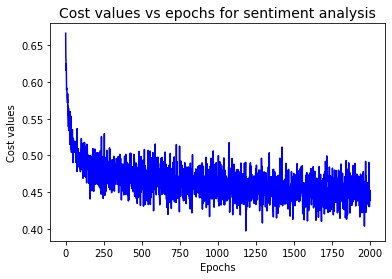

In [200]:
plt.plot(model_analysis_pre.batch_loss,'b')
plt.title("Cost values vs epochs for sentiment analysis",fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Cost values")
plt.show()

#### Accuracy test 

In [203]:
accuracy = model_analysis_pre.test(X_test_pre,Y_test_pre,CrossEntropy=True)
accuracy 

0.8038709677419354

## Conclusion

As we can see from the results of the experiments, the accuracy that the model with self-trained word vectors could reach is around 84%, whereas the accuracy that the model with pre-trained word vectors could reach is around 80%.<br>
<br>
There are several ways that we could further try to see if we could improve the performance of the model:

(1) Scrape more data

(2) Design word vectors with even higher dimensions. Higher dimensions of word vectors means that more latent features of words would be detected. However, this would require more training time and more space in your computer.

(3) Enlarge the instances of word vectors. In this project, we narrowed down to 6000 most frequent words for training the word vectors, which took around 50 minutes. We could further enlarge the instances up to 10000 or more. More words in word vectors means that more information could be gathered by the algorithm when doing sentiment analysis. By enlarging the instances of word vectors, more training time and space would be required.

(4) Enlarge the context size when training word vectors. Larger context size means that the algorithm could better figure out the context of a given word and thus yield a word vector which could better represent the given word.

(5) Tune hyperparameter of the model for training word vectors, such as balance factor, threshold, drop-out probability, score(weight factor), learning rate, etc.

(6) Tune hyperparameter of the model for sentiment analysis, such as batch size, learning rate, optimizer, etc.
